In [240]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import stockutils

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.ensemble import AdaBoostClassifier

from torch.utils.tensorboard import SummaryWriter

#track experiments
import wandb
from wandb.integration.xgboost import WandbCallback

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "exploratory_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

targetName = "2StBDayAftSDayBefore"


In [241]:
stockdf, targetdf, otherdf = stockutils.import_stock_csv("AAPL_Advanced.csv", target=targetName)
y_orig = targetdf["Target"]
print(y_orig.shape)
#targetdf.rename(columns={"DayAfterMajorReversal":'Target'}, inplace=True)
targetdf.head()

(2371,)


,Target
date,
1/13/2015,SELL
1/14/2015,SELL
1/15/2015,SELL
1/16/2015,SELL
1/20/2015,BUY


In [242]:
stockdf

,pct_Diff_from_6_day_SMA,Slope_6_day_SMA,Slope_4_day_SMA,CHLI_1Y,CHLI_1M,CHLI_2W,CHLI_1W,ADV_Issues,ADV_Vol,ADV_Issues_Comp,...,2yr_pct_chg,10yr_pct_chg,10yr_2yr_diff,10_2_diff_pct_chg,10_day_SMA,20_day_SMA,10_day_SMA_slope,20_day_SMA_slope,price_chg,vix_chg
date,,,,,,,,,,,,,,,,,,,,,
1/13/2015,0.006,0.006076,0.005625,0.519531,0.514604,0.412021,0.533840,0.487687,0.384596,0.485272,...,-0.014572,-0.002095,1.364,0.002941,27.39650,27.625750,-0.003356,0.000222,0.008879,0.96
1/14/2015,-0.003,0.005385,-0.004727,0.255924,0.239757,0.165829,0.219436,0.354120,0.325418,0.361974,...,-0.073937,-0.026247,1.354,-0.007331,27.32850,27.645440,-0.002482,0.000713,-0.003811,0.92
1/15/2015,-0.028,-0.001407,-0.011748,0.204082,0.179878,0.129602,0.179167,0.215686,0.145983,0.217218,...,-0.161677,-0.068464,1.308,-0.033973,27.23950,27.646375,-0.003257,0.000034,-0.027140,0.91
1/16/2015,-0.027,-0.008940,-0.007485,0.282353,0.257827,0.183930,0.268229,0.761533,0.803568,0.756293,...,0.161905,0.059606,1.343,0.026758,27.15600,27.603625,-0.003065,-0.001546,-0.007770,-1.44
1/20/2015,0.002,-0.005030,-0.003475,0.436364,0.394945,0.364068,0.463512,0.413196,0.522722,0.407381,...,0.022541,-0.021846,1.292,-0.037975,27.21775,27.554500,0.002274,-0.001780,0.025757,-1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6/7/2024,0.012,0.004818,0.003673,0.312500,0.232379,0.222092,0.278982,0.276359,0.332719,0.277529,...,0.034490,0.034056,-0.456,0.038724,192.94200,190.839000,0.005215,0.003238,0.012392,-0.36
6/10/2024,-0.009,0.000745,-0.001576,0.323194,0.215808,0.201844,0.261961,0.502888,0.547986,0.503411,...,-0.000818,0.008572,-0.414,-0.092105,193.25600,191.342500,0.001627,0.002638,-0.019148,0.52
6/11/2024,0.052,0.011226,0.014455,0.396476,0.226525,0.228319,0.313746,0.464976,0.463798,0.458442,...,-0.010440,-0.015433,-0.432,0.043478,194.97200,192.386000,0.008879,0.005454,0.072649,0.11


In [243]:
# make sure we split train and test data with shuffle OFF
X_train, X_test, y_train, y_test = train_test_split(stockdf,y_orig, train_size=0.8,shuffle=False)
# other_test will be used later to help evaluate the efficacy of our predictions, by calculating a return on investment
other_test = otherdf.iloc[-y_test.shape[0]:]

#my stockutils does not remove the index, so...
#y_test.reset_index(drop=True, inplace=True)
#y_train.reset_index(drop=True, inplace=True)


#Problem is for cross validation splits, this won't work, so...

# use a TimeSeriesSplit to do cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

In [244]:
y_test.shape

(475,)

In [245]:
wandb.login(key=os.environ.get("WANDB_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Base ROI

In [246]:
import math
bah_actuals = pd.DataFrame(data=y_test, columns=["Target"], index=y_test.index.copy())
bah_actuals['close'] = other_test['close']
max_ROI = stockutils.calculate_total_gains_bhs(bah_actuals, init_value=1000, init_price=bah_actuals['close'][0])

num_bought = math.floor(1000/ bah_actuals['close'][0])
bah_ROI = (bah_actuals['close'][-1] - bah_actuals['close'][0])
bah_ROI

Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 173.03, cash balance: $1128.5800000000002
Buying 7 shares for 142.99. Remaining Balance: 127.65000000000009
Selling all shares for 144.80, cash balance: $1141.2500000000002
Buying 7 shares for 146.87. Remaining Balance: 113.16000000000008
Selling all shares for 150.72, cash balance: $1168.2
Buying 9 shares for 129.62. Remaining Balance: 1.6200000000001182
Selling all shares for 153.20, cash balance: $1380.42
Buying 9 shares for 145.91. Remaining Balance: 67.23000000000002
Selling all shares for 195.83, cash balance: $1829.7
Buying 10 shares for 174.49. Remaining Balance: 84.79999999999995
Selling all shares for 189.46, cash balance: $1979.4
Buying 11 shares for 173.75. Remaining Balance: 68.15000000000009
Selling all shares for 179.80, cash balance: $2045.9500000000003
Buying 12 shares for 168.22. Remaining Balance: 27.3100000000004
Selling all shares for 197.96, cash balance: $2402.8300000000004
Bu

62.640000000000015

# Logistic Regression model

In [247]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import  LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

skf_cv = StratifiedKFold(n_splits = 8, shuffle=False)

#Use a time series split as the CV
tscv = TimeSeriesSplit(n_splits=8)

# This is actually a classifier, despite the name
lr = LogisticRegression(solver='liblinear', penalty='l1',max_iter=1000, random_state=42) 





# run this in a GridSearch for best parameters
lr_param_grid = {"C":[ 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                "solver": ['liblinear', 'lbfgs', 'newton-cg', 'sag'],
                }

#lrcv_gs = GridSearchCV(lr, lr_param_grid, cv=tscv, scoring='accuracy')
lrcv_gs = GridSearchCV(lr, lr_param_grid, cv=tscv, scoring='roc_auc')
# lrcv = LogisticRegressionCV(
#         Cs=list(np.power(10.0, np.arange(-10, 10)))
#         ,penalty='l2'
#         ,scoring='roc_auc'
#         ,cv=skf_cv
#         ,random_state=42
#         ,max_iter=10000
#         ,fit_intercept=True
#         ,solver='liblinear'#'newton-cg'
#         ,tol=10
#     )

lrcv_gs.fit(X_train, y_train) # could use orig, but has infinities still
# lrcv.fit(X_train, y_train)

y_pred = lrcv_gs.predict(X_test)

lr_best_params = lrcv_gs.best_params_
print("Best params:", lr_best_params)


#log to weights and biases
run_name = f"LogisticRegressionClassifier_{targetName}_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True, config=lr_best_params)

# y_pred_lrcv = lrcv.predict(X_test)
#log accuracy score
run.summary['accuracy'] = accuracy_score(y_test, y_pred)
print("Accuracy GS: ", accuracy_score(y_test, y_pred))
# print("Accuracy LRCV: ", accuracy_score(y_test, y_pred_lrcv))



print("Logistic Regression Classifier: {}".format(lrcv_gs.best_score_))

run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

lr_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
lr_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(lr_preds, init_value=1000, init_price=lr_preds['close'][0])
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "SELL"])

run.finish()

/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
192 fits failed out of a total of 256.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
64 fits failed with the following error:
Traceback (most recent call last):
  File "/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.p

Best params: {'C': 1, 'solver': 'liblinear'}


Accuracy GS:  0.6884210526315789
Logistic Regression Classifier: 0.806163009454633
Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 163.62, cash balance: $1072.1200000000001
Buying 6 shares for 163.43. Remaining Balance: 91.54000000000008
Selling all shares for 153.84, cash balance: $1014.58
Buying 6 shares for 156.90. Remaining Balance: 73.17999999999995
Selling all shares for 153.72, cash balance: $995.4999999999999
Buying 6 shares for 143.75. Remaining Balance: 132.9999999999999
Selling all shares for 143.39, cash balance: $993.3399999999998
Buying 6 shares for 147.27. Remaining Balance: 109.71999999999969
Selling all shares for 144.80, cash balance: $978.5199999999998
Buying 6 shares for 155.74. Remaining Balance: 44.0799999999997
Selling all shares for 145.03, cash balance: $914.2599999999998
Buying 6 shares for 146.87. Remaining Balance: 33.039999999999736
Selling all shares for 141.17, cash balance: $880.0599999999997
Buying 5 shares for 14

Buy And Hold (Base ROI),62.64
Max ROI,2143.55
ROI,292.78
accuracy,0.68842


In [248]:
y_pred

array(['BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
       'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
       'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'SELL', 'SELL', 'SELL', 'SELL',
       'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'BUY', 'SELL',
       'SELL', 'SELL', 'SELL', 'SELL', 'BUY', 'SELL', 'SELL', 'SELL',
       'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL',
       'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL',
       'BUY', 'BUY', 'SELL', 'BUY', 'BUY', 'BUY', 'BUY', 'SELL', 'BUY',
       'BUY', 'BUY', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL',
       'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
       'BUY', 'BUY', 'BUY', 'SELL', 'BUY', 'BUY', 'BUY', 'BUY', 'SELL',
       'SELL', 'SELL', 'SELL', 'BUY', 'BUY', 'BUY', 'SELL', 'SELL',
       'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL',
       'SELL', 'SELL', 'SELL', 'SELL', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY',
       '

<Axes: >

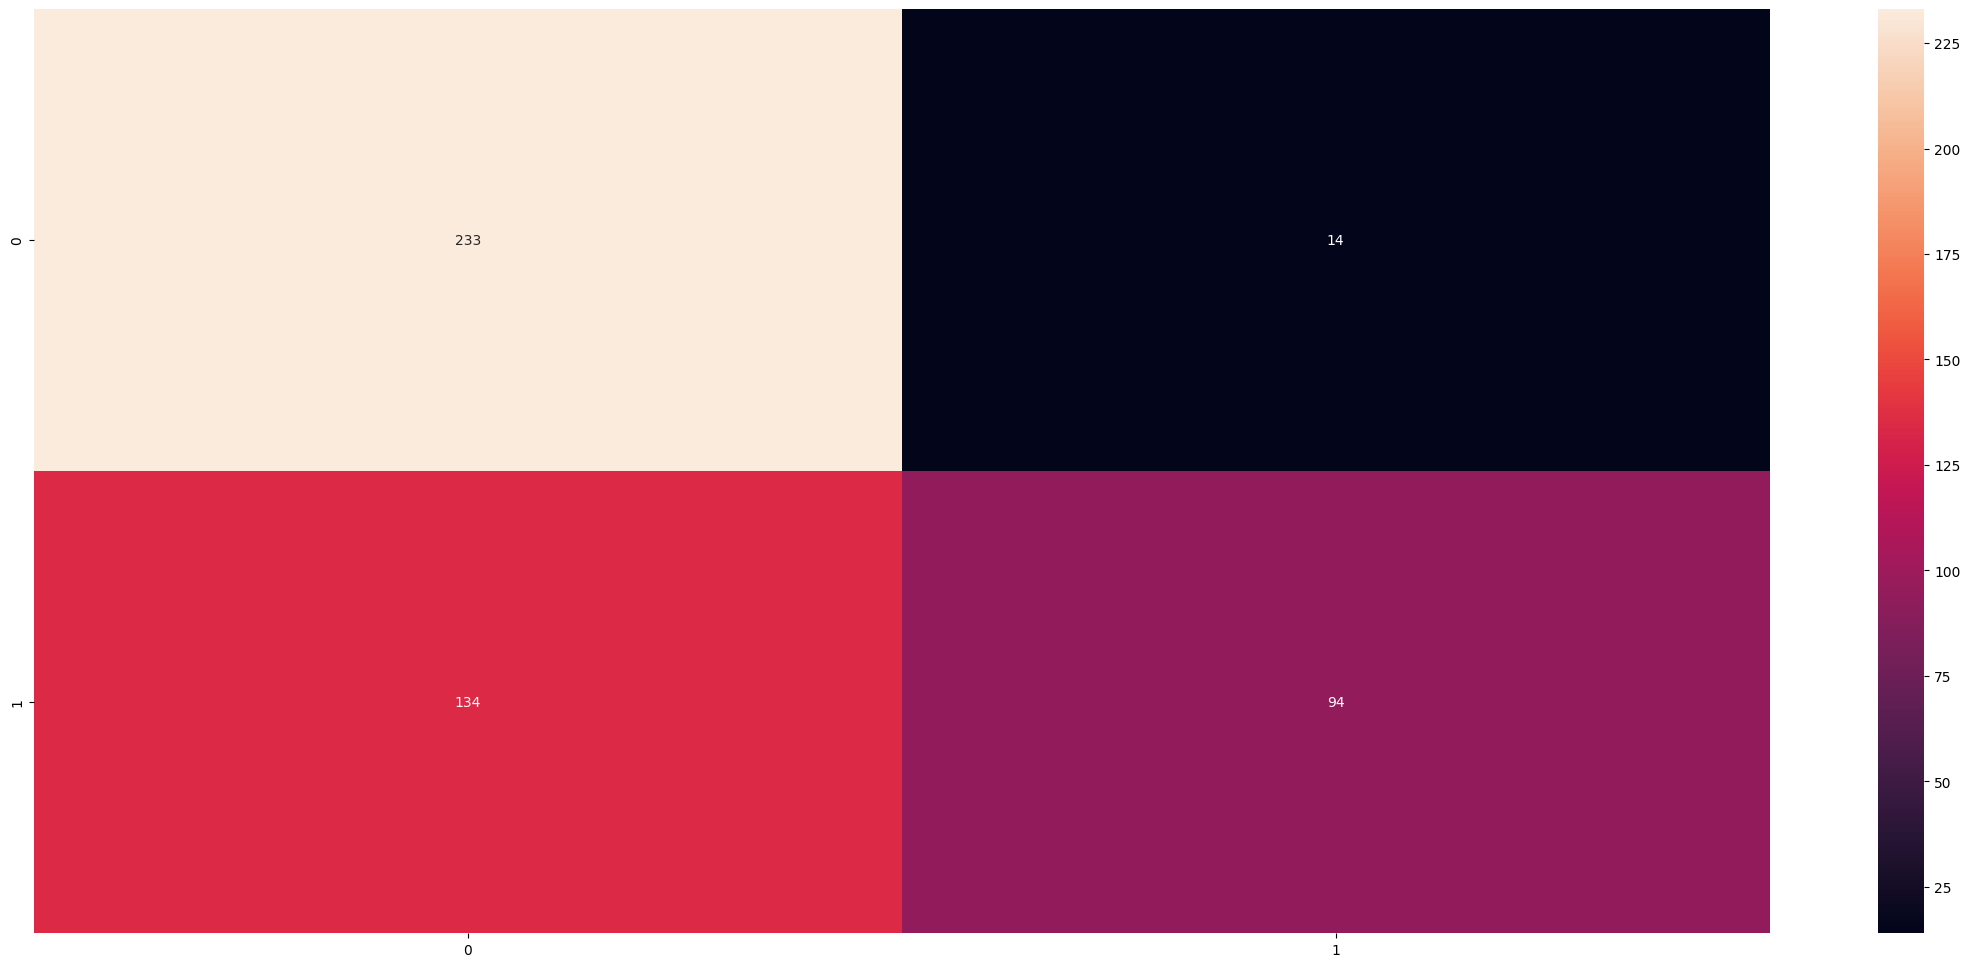

In [249]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

In [250]:
#sns.heatmap(confusion_matrix(y_test, y_pred_lrcv), annot=True, fmt="d")

# K Nearest Neighbors Classifier

In [251]:
from sklearn.neighbors import KNeighborsClassifier

knn_param_grid = {"n_neighbors":[1,2,4,8,16,32],
                  "weights":['uniform','distance'],
                  'leaf_size':[5,10,15,20,30,40]}

knn_cls = KNeighborsClassifier()

knn_gs= GridSearchCV(knn_cls, param_grid=knn_param_grid, scoring='roc_auc',cv=tscv)

knn_gs.fit(X_train, y_train)
print("Best params:", knn_gs.best_params_)
print("KNN Classifier: {}".format(knn_gs.best_score_))

y_pred = knn_gs.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))


best_knn = knn_gs.best_estimator_
print("Best params:", knn_gs.best_estimator_.get_params())

Best params: {'leaf_size': 5, 'n_neighbors': 4, 'weights': 'distance'}
KNN Classifier: 0.534039783440474
Accuracy:  0.4884210526315789
Best params: {'algorithm': 'auto', 'leaf_size': 5, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}


<Axes: >

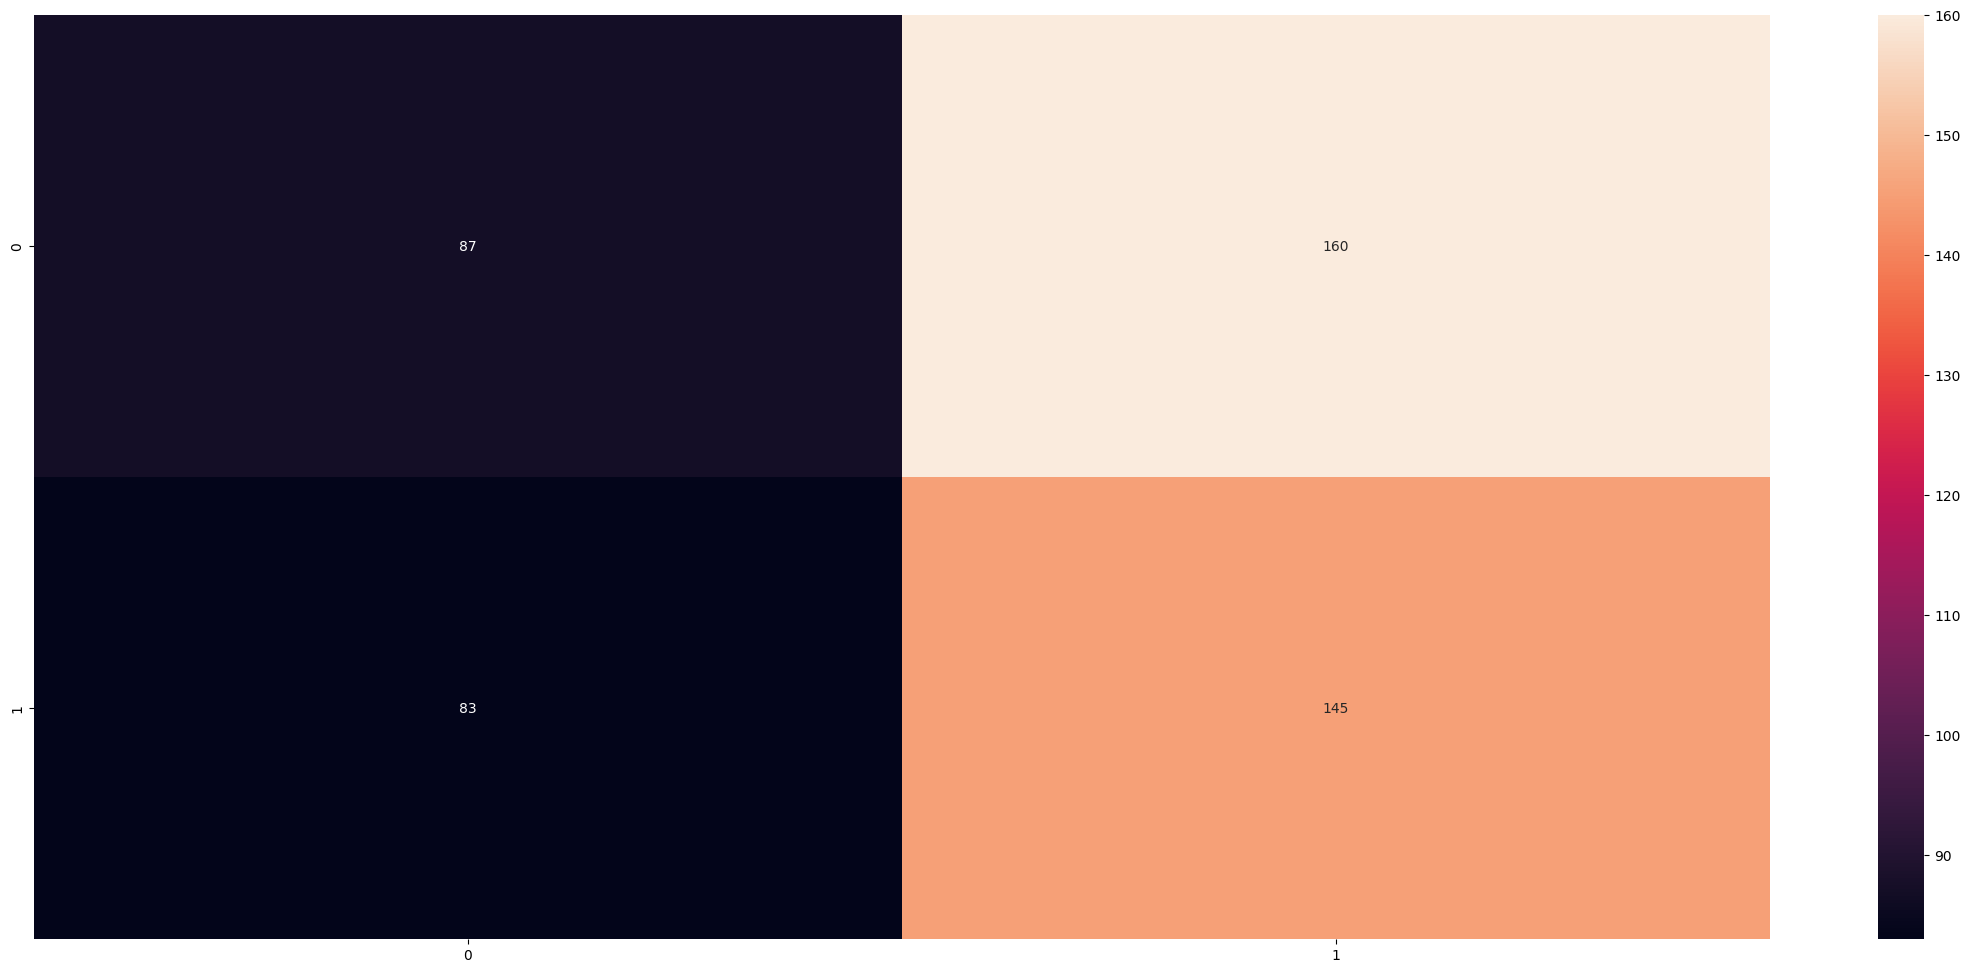

In [252]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

I didn't really have hope for this one, since the data does not have clean separation.
I won't even log this

# Decision Tree Classifier

In [253]:
#wandb.init(entity="christopherandrews", project="StockPredictor", name="DecisionTreeClassifier_v01", save_code=False)

In [254]:
y_test.head()

date
7/26/2022    BUY
7/27/2022    BUY
7/28/2022    BUY
7/29/2022    BUY
8/1/2022     BUY
Name: Target, dtype: object

In [255]:


# Create the DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=2, random_state=2)

#set up for a Grid Search 
dtc_param_grid = {'max_depth':[1,2,3,4,5,6,7], 
                  'min_samples_split': [2,4,8,16,32,64], 
                  'min_samples_leaf': [2,4,8,16,32,64]}



#Perform the training with a grid search
dtc_gs = GridSearchCV(dt, param_grid=dtc_param_grid, cv=tscv, scoring='accuracy', verbose=True)
dtc_gs.fit(X_train, y_train)

y_pred = dtc_gs.predict(X_test) #uses best estimator
config = dtc_gs.best_params_

#log to weights and biases
run_name = f"DecisionTreeClassifier_{targetName}_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True, config=config)

#log accuracy score
run.summary['accuracy'] = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
dtc_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
dtc_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(dtc_preds, init_value=1000, init_price=dtc_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "SELL"])

run.finish()

Fitting 8 folds for each of 252 candidates, totalling 2016 fits


Accuracy:  0.7663157894736842
Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 167.57, cash balance: $1095.8200000000002
Buying 6 shares for 170.03. Remaining Balance: 75.6400000000001
Selling all shares for 163.62, cash balance: $1057.3600000000001
Buying 6 shares for 163.43. Remaining Balance: 76.78000000000009
Selling all shares for 153.84, cash balance: $999.82
Buying 6 shares for 154.48. Remaining Balance: 72.94000000000017
Selling all shares for 150.43, cash balance: $975.5200000000002
Buying 6 shares for 142.99. Remaining Balance: 117.58000000000015
Selling all shares for 138.38, cash balance: $947.8600000000001
Buying 6 shares for 142.41. Remaining Balance: 93.40000000000009
Selling all shares for 143.86, cash balance: $956.5600000000002
Buying 6 shares for 143.39. Remaining Balance: 96.22000000000025
Selling all shares for 144.80, cash balance: $965.0200000000003
Buying 6 shares for 155.74. Remaining Balance: 30.58000000000027
Selling all

Buy And Hold (Base ROI),62.64
Max ROI,2143.55
ROI,295.07
accuracy,0.76632


In [256]:
#In case the above fails
#run.finish()

<Axes: >

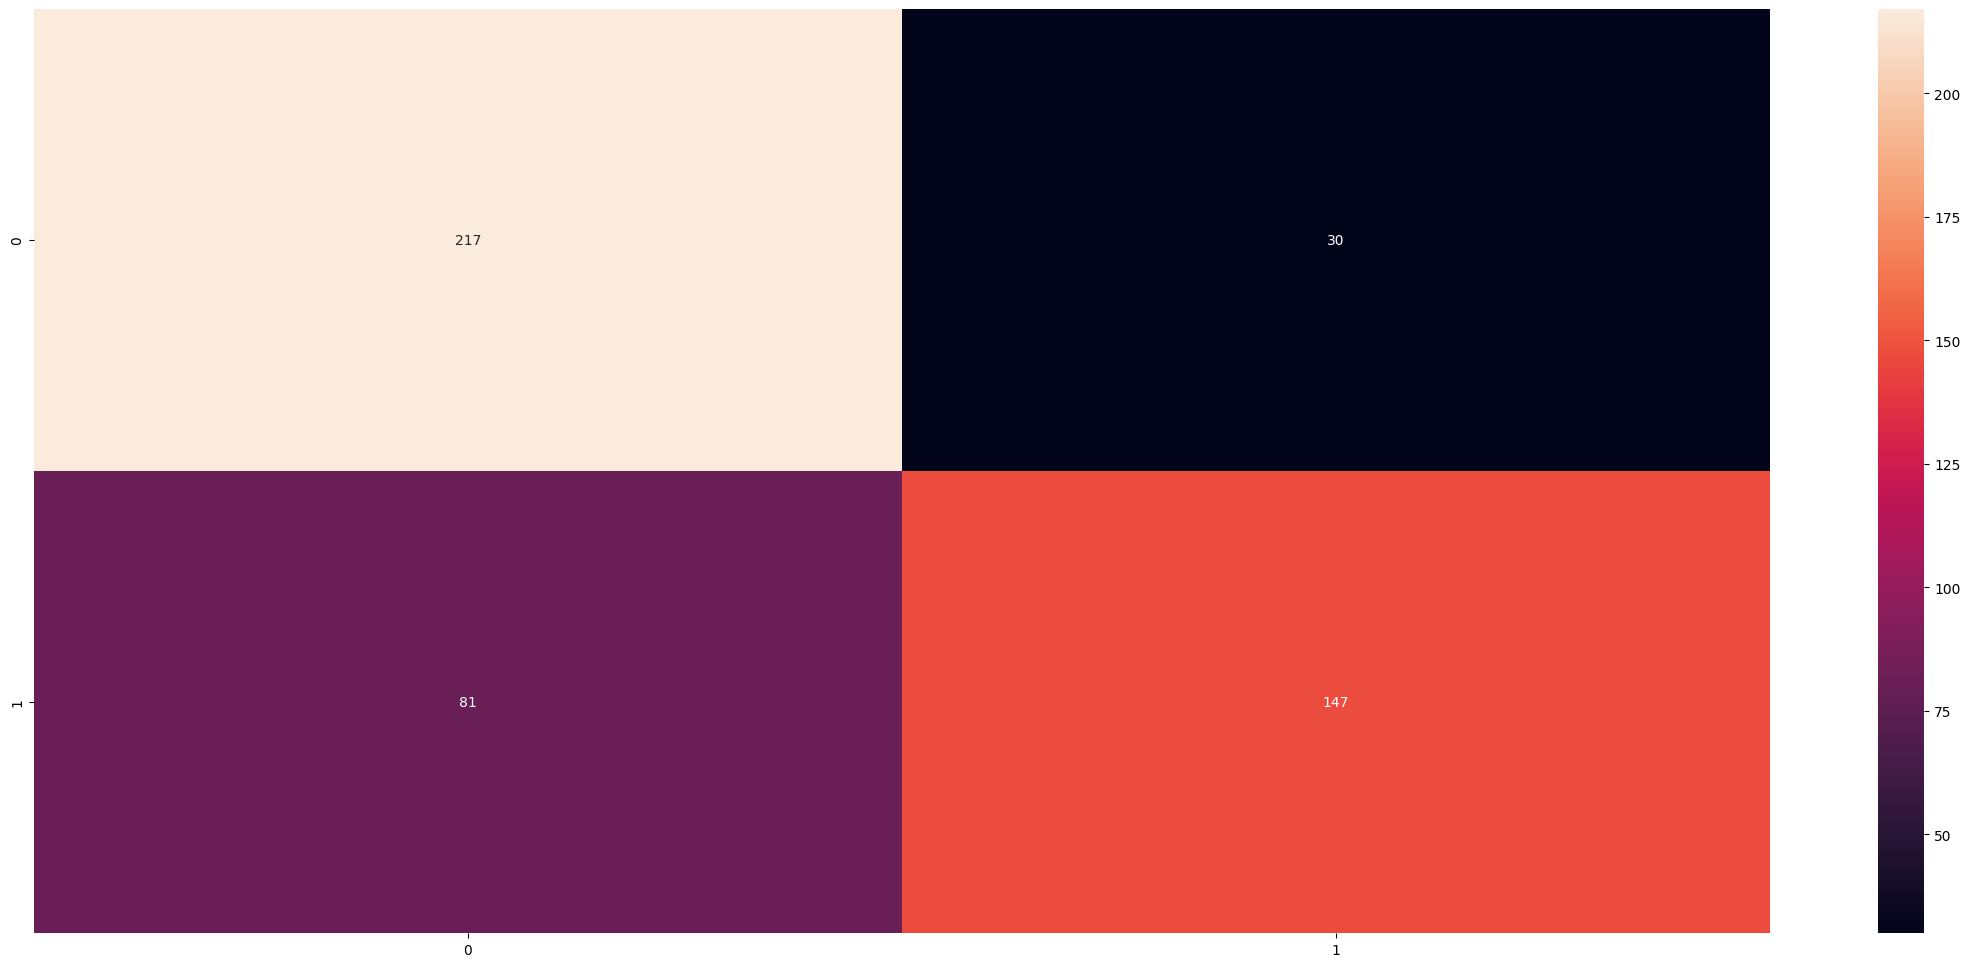

In [257]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

Hold seems to be a problem...

56% accuracy, hmmm...  that's hardly better than just a guess!

In [258]:
# Get the best paramters from the model
dtc_gs.best_params_

{'max_depth': 4, 'min_samples_leaf': 64, 'min_samples_split': 2}

In [259]:
outputfilepath = os.path.join(IMAGES_PATH, "GridSearchDTC.dot")
export_graphviz(dtc_gs.best_estimator_, out_file=outputfilepath, feature_names=X_train.columns, class_names=["BUY",'SELL'], rounded=True, filled=True )

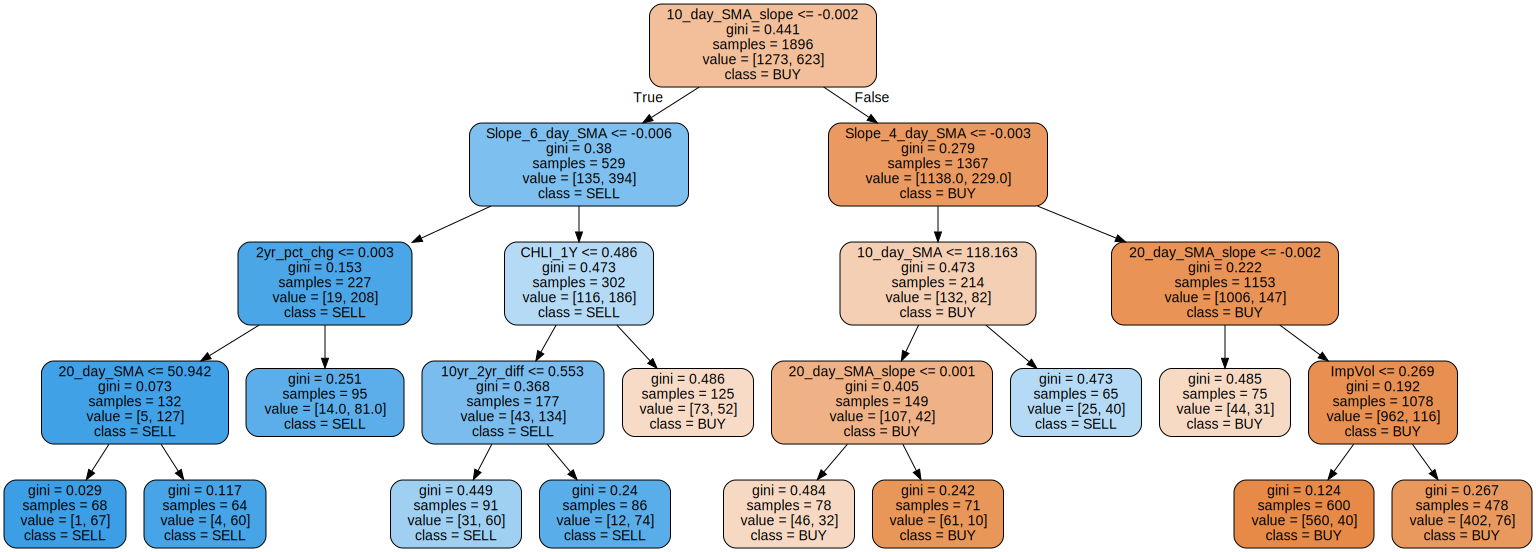

In [260]:
Source.from_file(outputfilepath)

<Axes: >

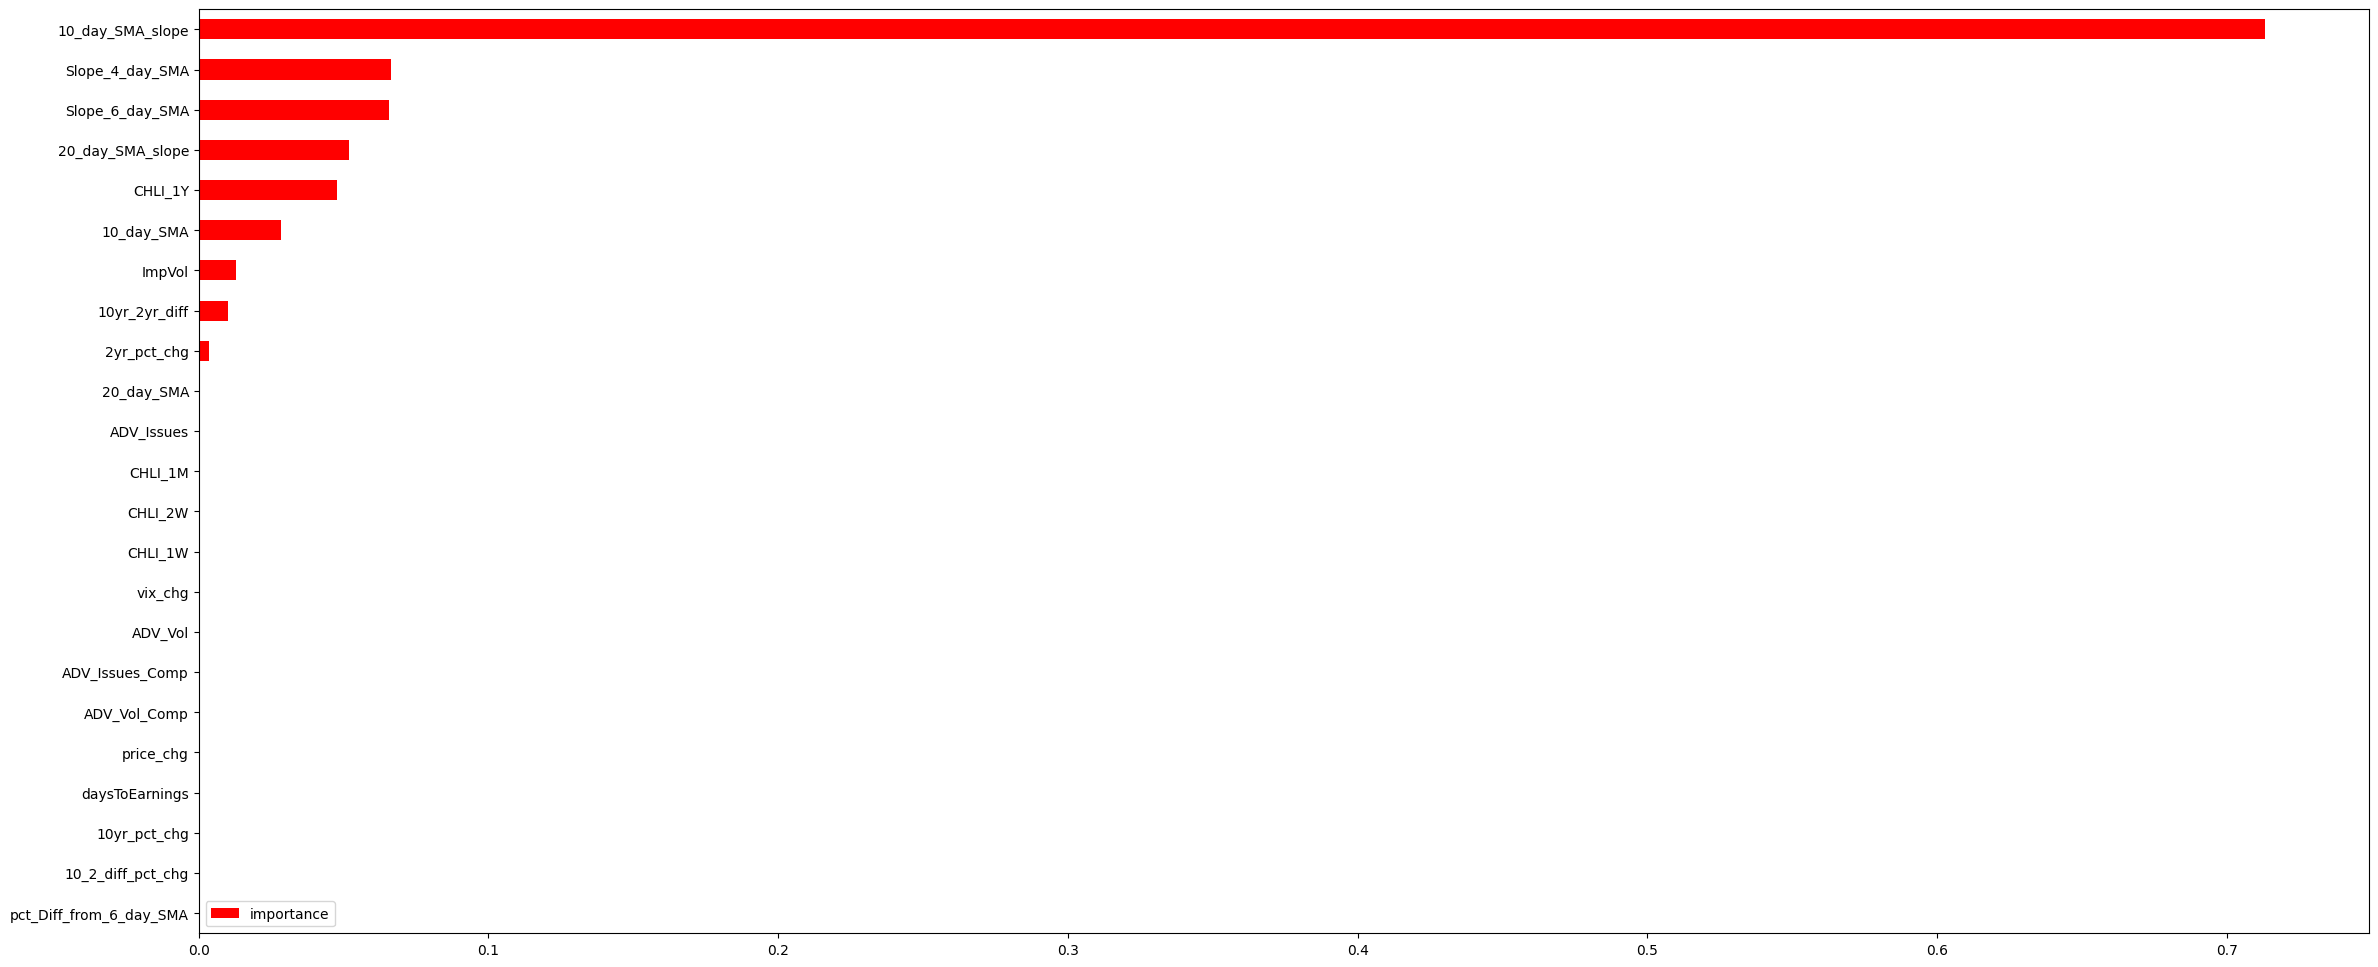

In [261]:
feature_importances = list(zip(X_train.columns, dtc_gs.best_estimator_.feature_importances_))
fi = pd.Series(dtc_gs.best_estimator_.feature_importances_, index=X_train.columns)
sorted_imp = pd.DataFrame(fi.sort_values(ascending=True), columns=['importance'])
sorted_imp.plot(kind='barh',color="red")

It only seems to want to use the 6 and 10 day SMA slope...

# AdaBoost Classifier


In [262]:
adb_param_grid = {"learning_rate":[0.001, 0.01, 0.1],
                  'n_estimators':[50, 100, 200] }

#log to weights and biases
run_name = f"AdaBoostClassifier_{targetName}_{int(time.time())}"

adb_clf = AdaBoostClassifier(estimator=dt, algorithm='SAMME', n_estimators=200, random_state=42)

adb_gs = GridSearchCV(adb_clf, param_grid=adb_param_grid, cv=tscv, scoring='roc_auc', verbose=True)# was accuracy

adb_gs.fit(X_train, y_train)

y_pred = adb_gs.predict(X_test) #uses best estimator

config = adb_gs.best_params_

#log to weights and biases

run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True, config=config)

run.summary['accuracy'] = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))


# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
adb_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
adb_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(adb_preds, init_value=1000, init_price=adb_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "SELL"])

run.finish()

Fitting 8 folds for each of 9 candidates, totalling 72 fits


Accuracy:  0.7768421052631579
Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 163.62, cash balance: $1072.1200000000001
Buying 6 shares for 163.43. Remaining Balance: 91.54000000000008
Selling all shares for 153.84, cash balance: $1014.58
Buying 6 shares for 154.48. Remaining Balance: 87.70000000000016
Selling all shares for 150.43, cash balance: $990.2800000000002
Buying 6 shares for 151.76. Remaining Balance: 79.72000000000025
Selling all shares for 149.84, cash balance: $978.7600000000002
Buying 6 shares for 142.99. Remaining Balance: 120.82000000000016
Selling all shares for 143.86, cash balance: $983.9800000000002
Buying 6 shares for 143.39. Remaining Balance: 123.64000000000033
Selling all shares for 138.88, cash balance: $956.9200000000003
Buying 6 shares for 146.87. Remaining Balance: 75.70000000000027
Selling all shares for 149.70, cash balance: $973.9000000000002
Buying 6 shares for 150.04. Remaining Balance: 73.6600000000002
Selling al

Buy And Hold (Base ROI),62.64
Max ROI,2143.55
ROI,537.09
accuracy,0.77684


<Axes: >

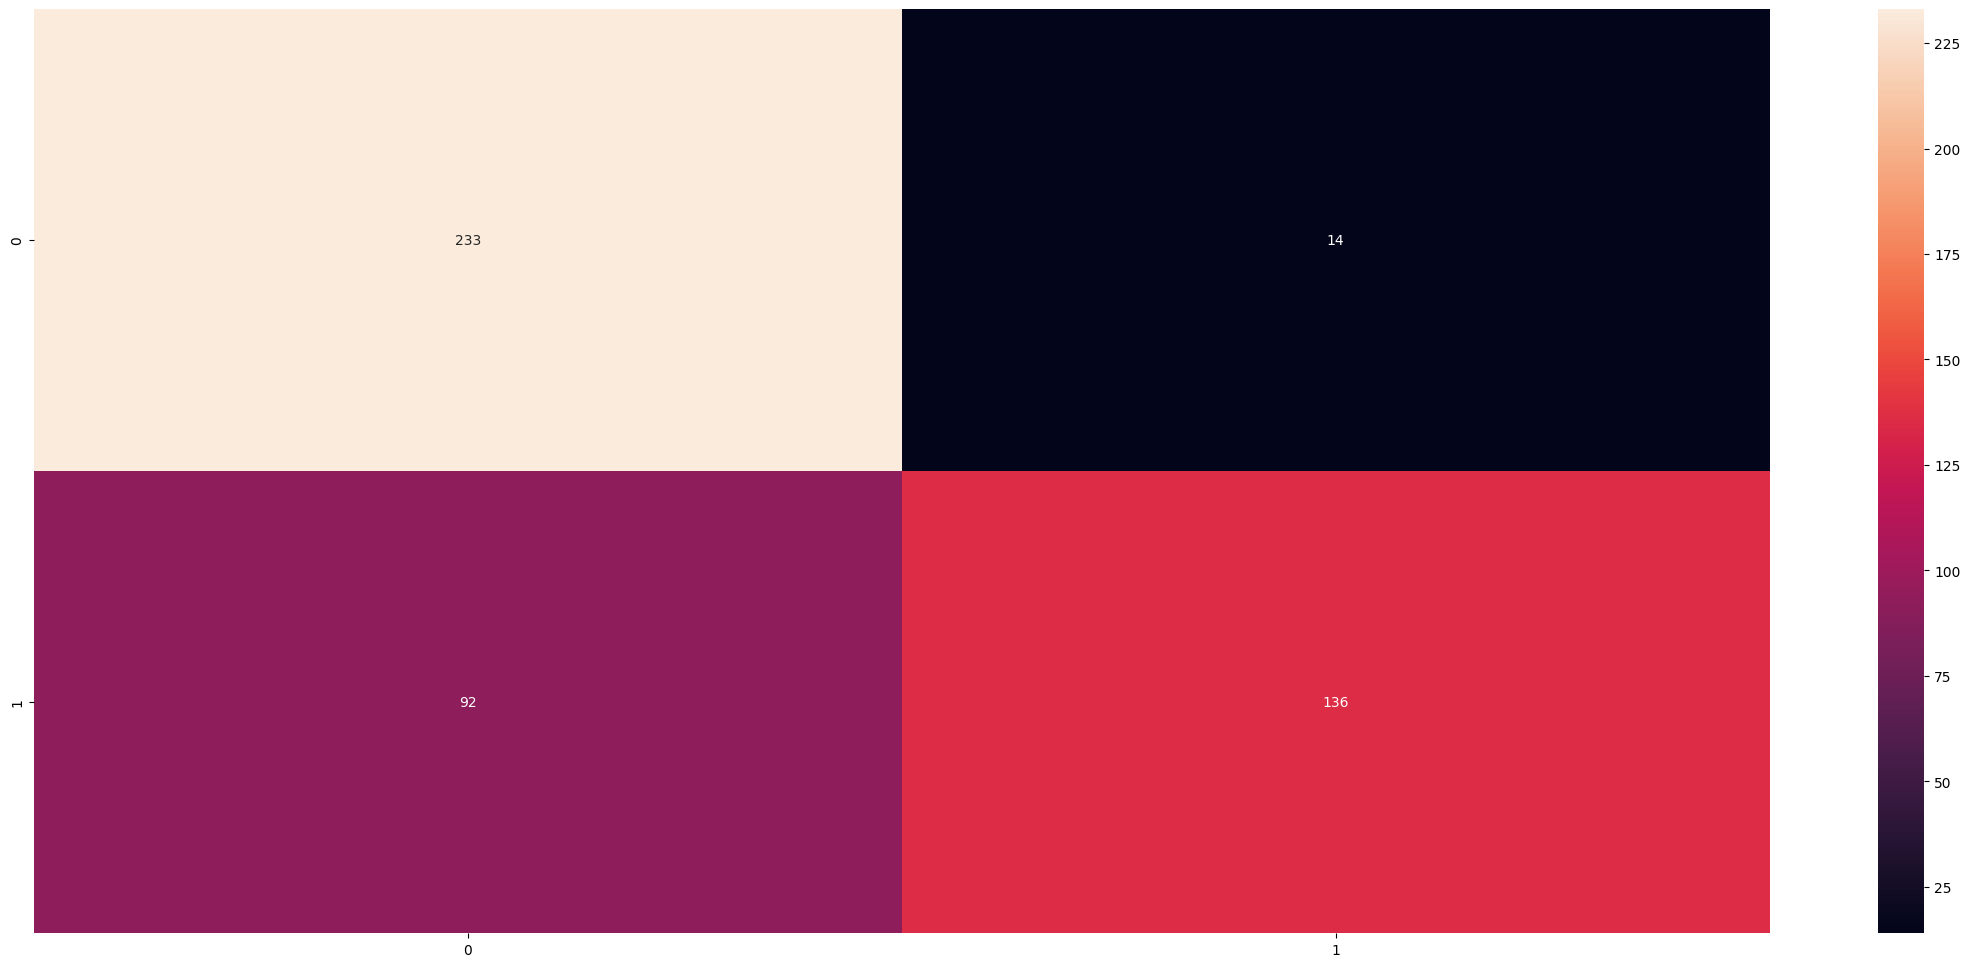

In [263]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

<Axes: >

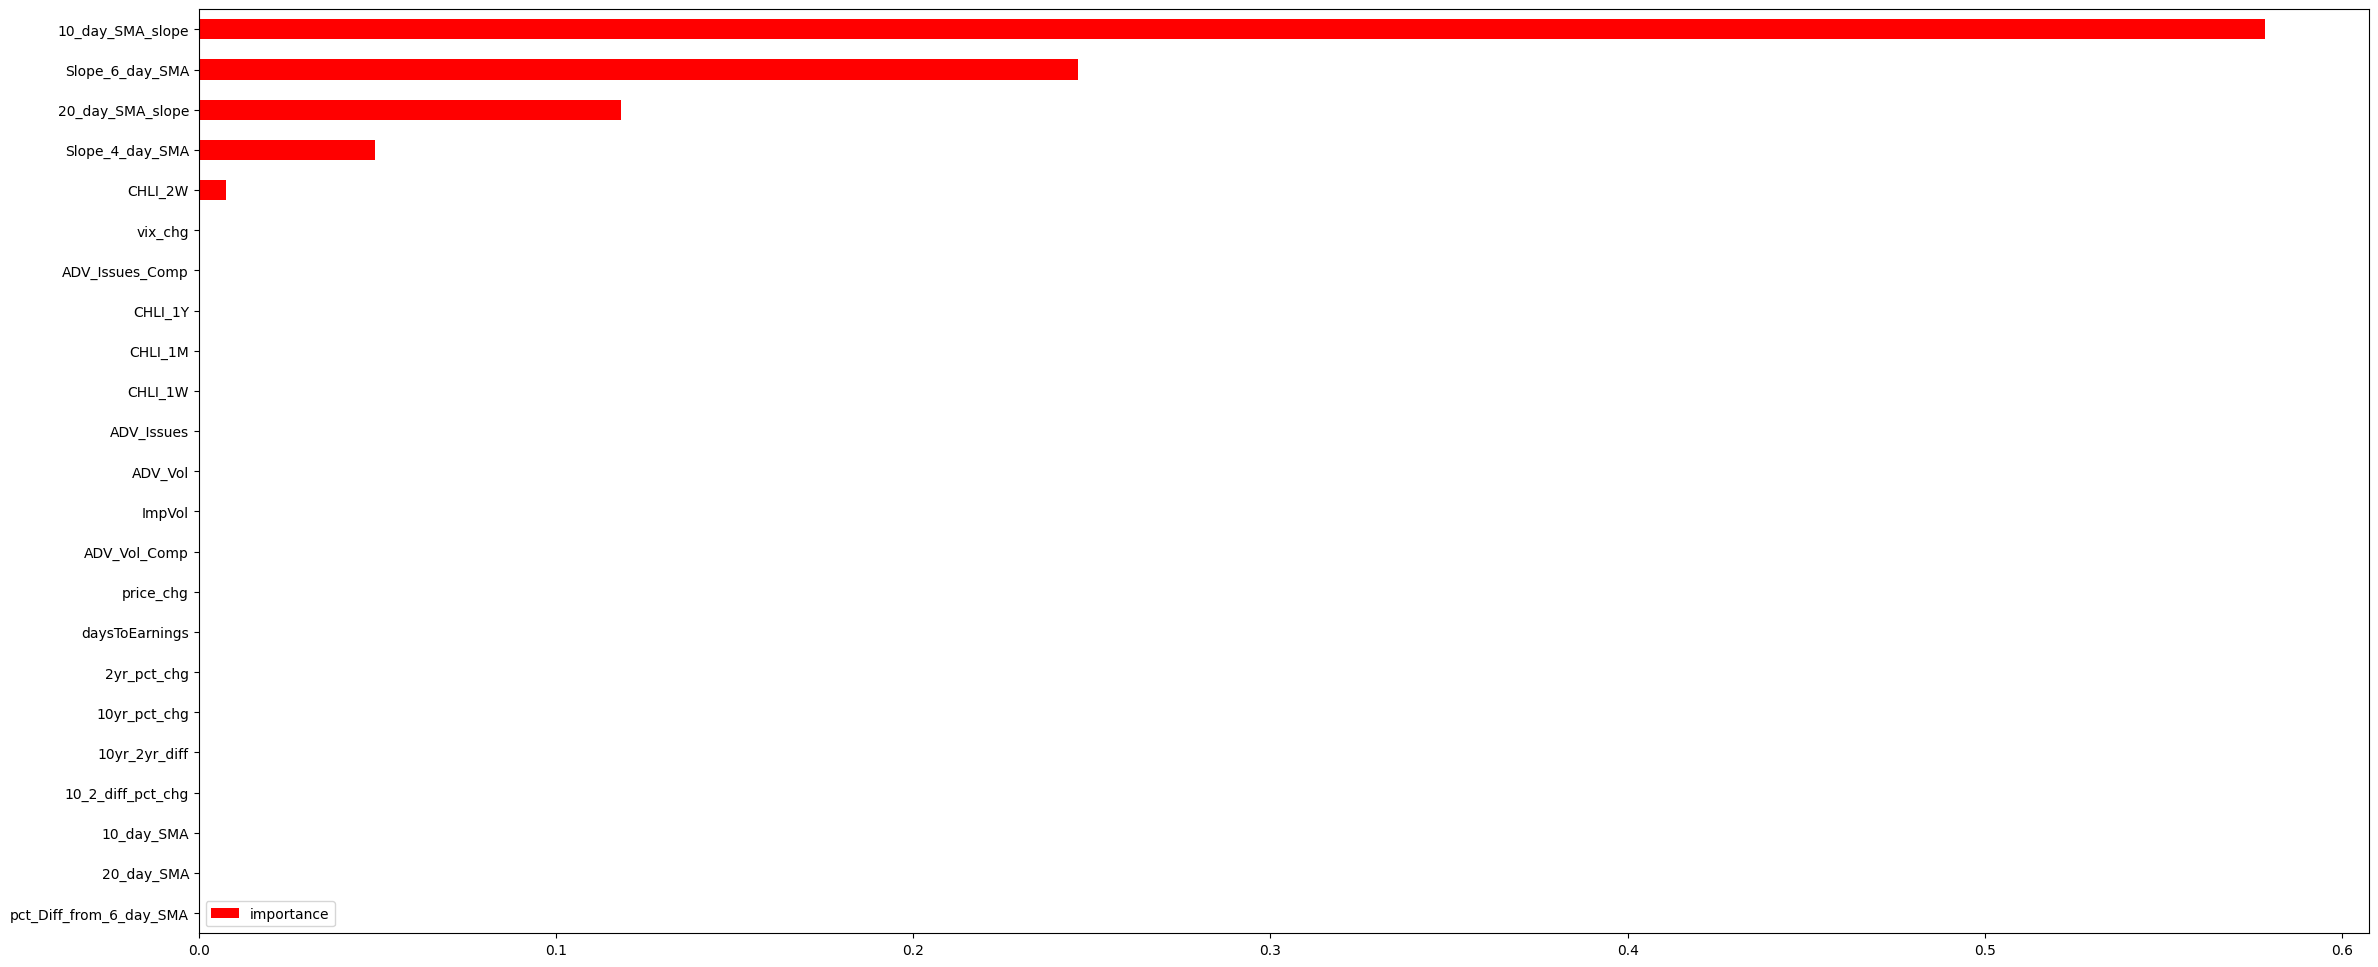

In [264]:
feature_importances = list(zip(X_train.columns, adb_gs.best_estimator_.feature_importances_))
fi = pd.Series(adb_gs.best_estimator_.feature_importances_, index=X_train.columns)
sorted_imp = pd.DataFrame(fi.sort_values(ascending=True), columns=['importance'])
sorted_imp.plot(kind='barh',color="red")

We end up using a few more features, and get a fairly surprising 64% accuracy.

# Gradient Boosting Classifier

In [265]:
from sklearn.ensemble import GradientBoostingClassifier

# adb_param_grid = {"learning_rate":[0.001, 0.01, 0.1],
#                   'n_estimators':[50, 100, 200] }

#log to weights and biases
run_name = f"GradientBoostClassifier_{targetName}_{int(time.time())}"



#Use a time series split as the CV
tscv = TimeSeriesSplit(n_splits=8)

gbc = GradientBoostingClassifier(max_depth=2, random_state=42, loss='log_loss')

gbc_params = {'learning_rate':[0.001], 'n_estimators':[ 800]}

#RandomizedSearchCV
gbc_gs = GridSearchCV(gbc, param_grid=gbc_params, cv=tscv, scoring='roc_auc', verbose=True)

gbc_gs.fit(X_train, y_train)


y_pred = gbc_gs.predict(X_test) #uses best estimator
#y_probas = gbc_gs.predict_proba(X_test)

config = gbc_gs.best_params_
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True, config=config)

run.summary['accuracy'] = accuracy_score(y_test, y_pred)
#run.summary['precision'] = precision_score(y_test, y_pred)
#run.summary['recall'] = recall_score(y_test, y_pred)

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
gbc_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
gbc_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(gbc_preds, init_value=1000, init_price=gbc_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

print("Accuracy: ", accuracy_score(y_test, y_pred))
#wandb.sklearn.plot_roc(y_test, y_probas, ["BUY", "HOLD", "SELL"])
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "SELL"])
#wandb.sklearn.plot_learning_curve(gbc_gs.best_estimator_, X_train, y_train)
run.finish()

Fitting 8 folds for each of 1 candidates, totalling 8 fits


Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 163.62, cash balance: $1072.1200000000001
Buying 6 shares for 163.43. Remaining Balance: 91.54000000000008
Selling all shares for 153.84, cash balance: $1014.58
Buying 6 shares for 154.48. Remaining Balance: 87.70000000000016
Selling all shares for 150.43, cash balance: $990.2800000000002
Buying 6 shares for 151.76. Remaining Balance: 79.72000000000025
Selling all shares for 149.84, cash balance: $978.7600000000002
Buying 6 shares for 142.99. Remaining Balance: 120.82000000000016
Selling all shares for 138.88, cash balance: $954.1000000000001
Buying 6 shares for 146.87. Remaining Balance: 72.88000000000011
Selling all shares for 144.22, cash balance: $938.2
Buying 6 shares for 148.03. Remaining Balance: 50.01999999999998
Selling all shares for 140.94, cash balance: $895.66
Buying 6 shares for 144.49. Remaining Balance: 28.719999999999914
Selling all shares for 143.21, cash balance: $887.979999999999

Buy And Hold (Base ROI),62.64
Max ROI,2143.55
ROI,347.22
accuracy,0.72


This is quite slow compared to XGBoost

In [266]:
wandb.finish()

In [267]:
gbc_gs.best_params_

{'learning_rate': 0.001, 'n_estimators': 800}

<Axes: >

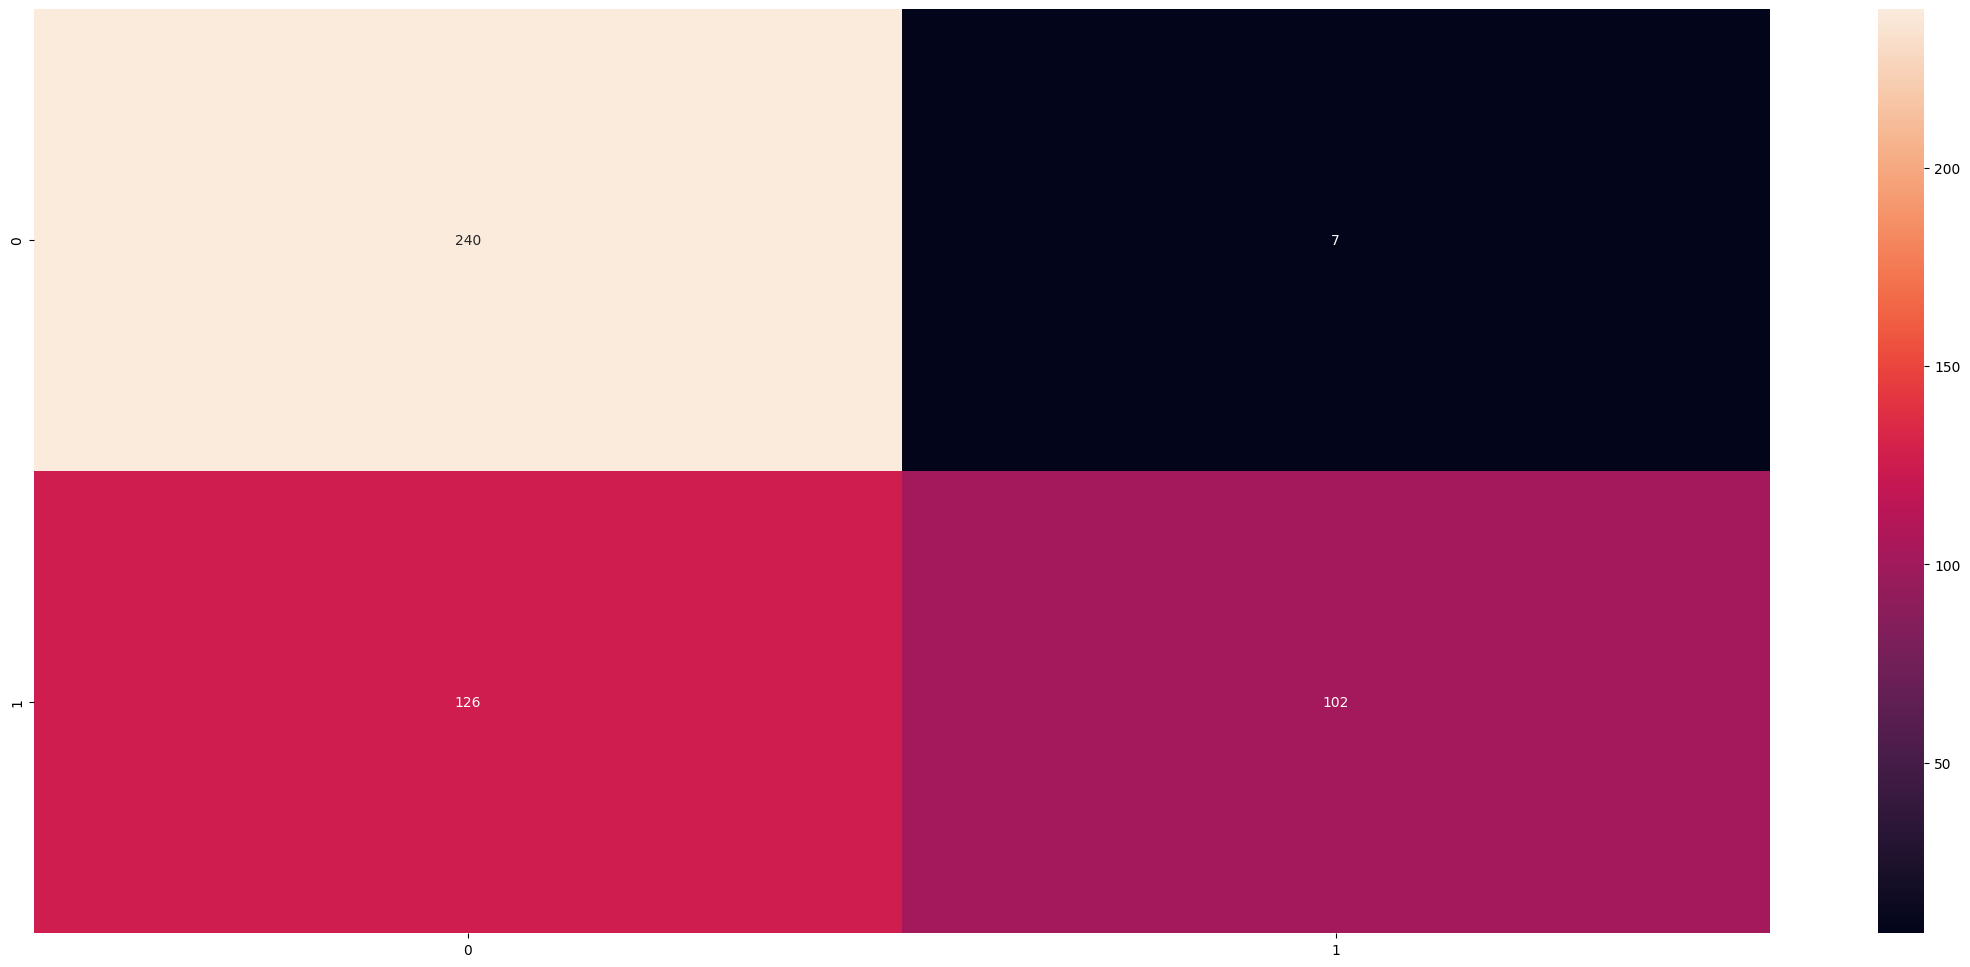

In [268]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

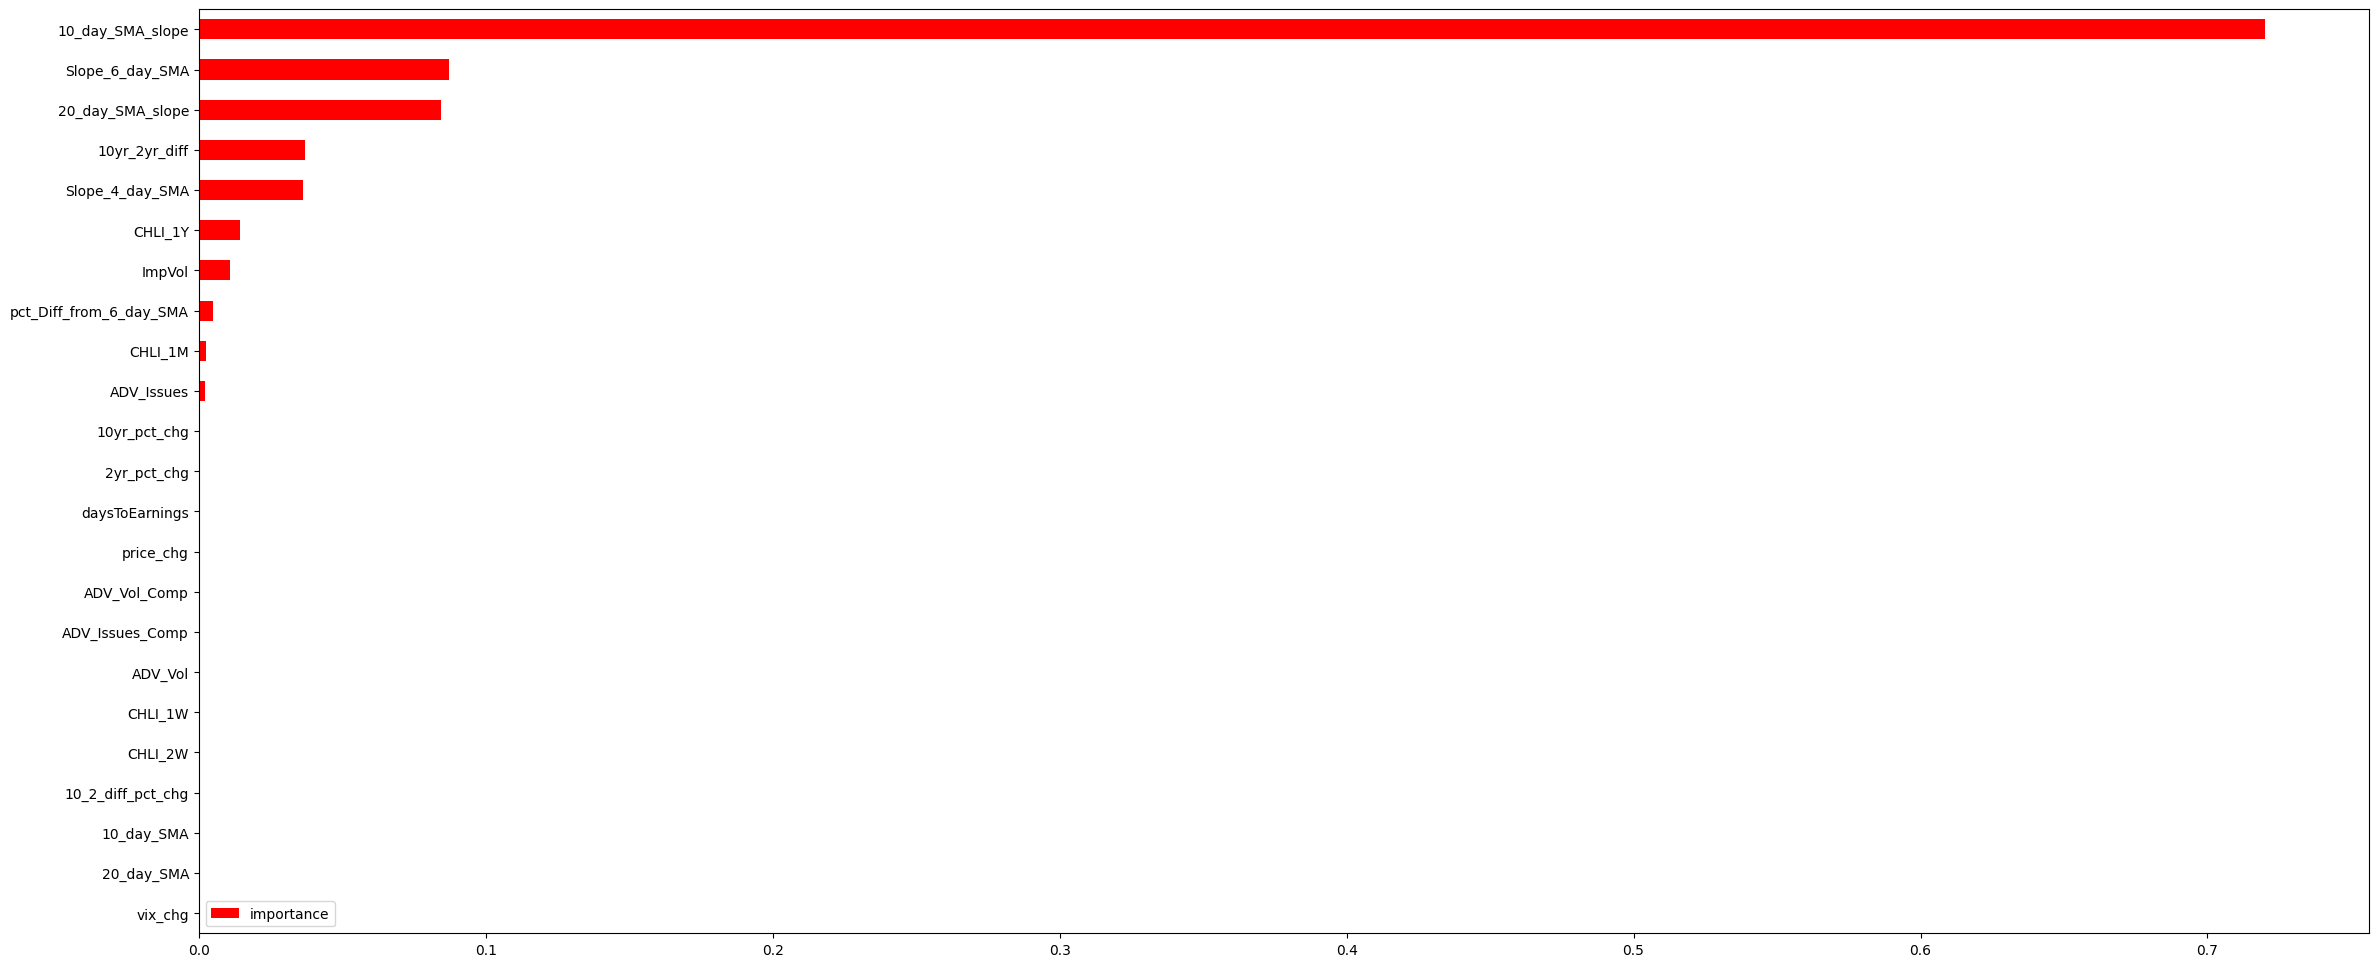

In [269]:
stockutils.plot_feature_importances(X_train=X_train, estimator=gbc_gs.best_estimator_)



BUT, it always predicts a buy or sell, never hold!  

# Random Forest Classifier

In [270]:
from sklearn.ensemble import RandomForestClassifier

In [271]:

#log to weights and biases
run_name = f"RandomForestClassifier_{targetName}_{int(time.time())}"


#tscv = TimeSeriesSplit(n_splits=8)
tscv = 10

#cls = StackingClassifier(max_depth=2, random_state=42, loss='log_loss')
cls = RandomForestClassifier(random_state=42)

#Base classifier 
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

print("Base classifier accuracy:", accuracy_score(y_test, y_pred))


#gbc_params = {'learning_rate':[0.001, 0.01, 0.1, 1, 10], 'n_estimators':[100,200,300]}
cls_params = {'max_depth':[2, 4, 6], 'n_estimators':[100, 200, 400, 800, 1000], 'max_features': [2, 4, 6 ]}

rf_gs = RandomizedSearchCV(cls, param_distributions=cls_params, cv=tscv, scoring='roc_auc', verbose=True)

rf_gs.fit(X_train, y_train)

y_pred = rf_gs.predict(X_test) #uses best estimator
#y_probas = gbc_gs.predict_proba(X_test)

config = rf_gs.best_params_

run = wandb.init(entity="christopherandrews", 
                project="StockPredictor", 
                name=run_name, save_code=False, 
                settings=wandb.Settings(start_method="fork"), 
                reinit=True, 
                sync_tensorboard=True,
                config=config)

run.summary['accuracy'] = accuracy_score(y_test, y_pred)
#run.summary['precision'] = precision_score(y_test, y_pred)
#run.summary['recall'] = recall_score(y_test, y_pred)
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text("hyperparameters",
                "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in rf_gs.best_params_.items()]))
)

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
rf_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
rf_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(rf_preds, init_value=1000, init_price=rf_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

print("Accuracy: ", accuracy_score(y_test, y_pred))
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY",  "SELL"])

run.finish()

Base classifier accuracy: 0.7410526315789474
Fitting 10 folds for each of 10 candidates, totalling 100 fits


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 167.57, cash balance: $1095.8200000000002
Buying 6 shares for 170.03. Remaining Balance: 75.6400000000001
Selling all shares for 163.62, cash balance: $1057.3600000000001
Buying 6 shares for 163.43. Remaining Balance: 76.78000000000009
Selling all shares for 153.84, cash balance: $999.82
Buying 6 shares for 154.48. Remaining Balance: 72.94000000000017
Selling all shares for 156.90, cash balance: $1014.3400000000003
Buying 6 shares for 153.72. Remaining Balance: 92.02000000000032
Selling all shares for 150.43, cash balance: $994.6000000000004
Buying 6 shares for 142.99. Remaining Balance: 136.6600000000003
Selling all shares for 138.38, cash balance: $966.9400000000003
Buying 6 shares for 142.41. Remaining Balance: 112.48000000000025
Selling all shares for 138.88, cash balance: $945.7600000000002
Buying 6 shares for 146.87. Remaining Balance: 64.54000000000019
Selling all shares for 144.22, cash bala

Buy And Hold (Base ROI),62.64
Max ROI,2143.55
ROI,360.6
accuracy,0.74526


In [272]:
wandb.finish()

In [273]:
rf_gs.best_params_

{'n_estimators': 200, 'max_features': 4, 'max_depth': 2}

<Axes: >

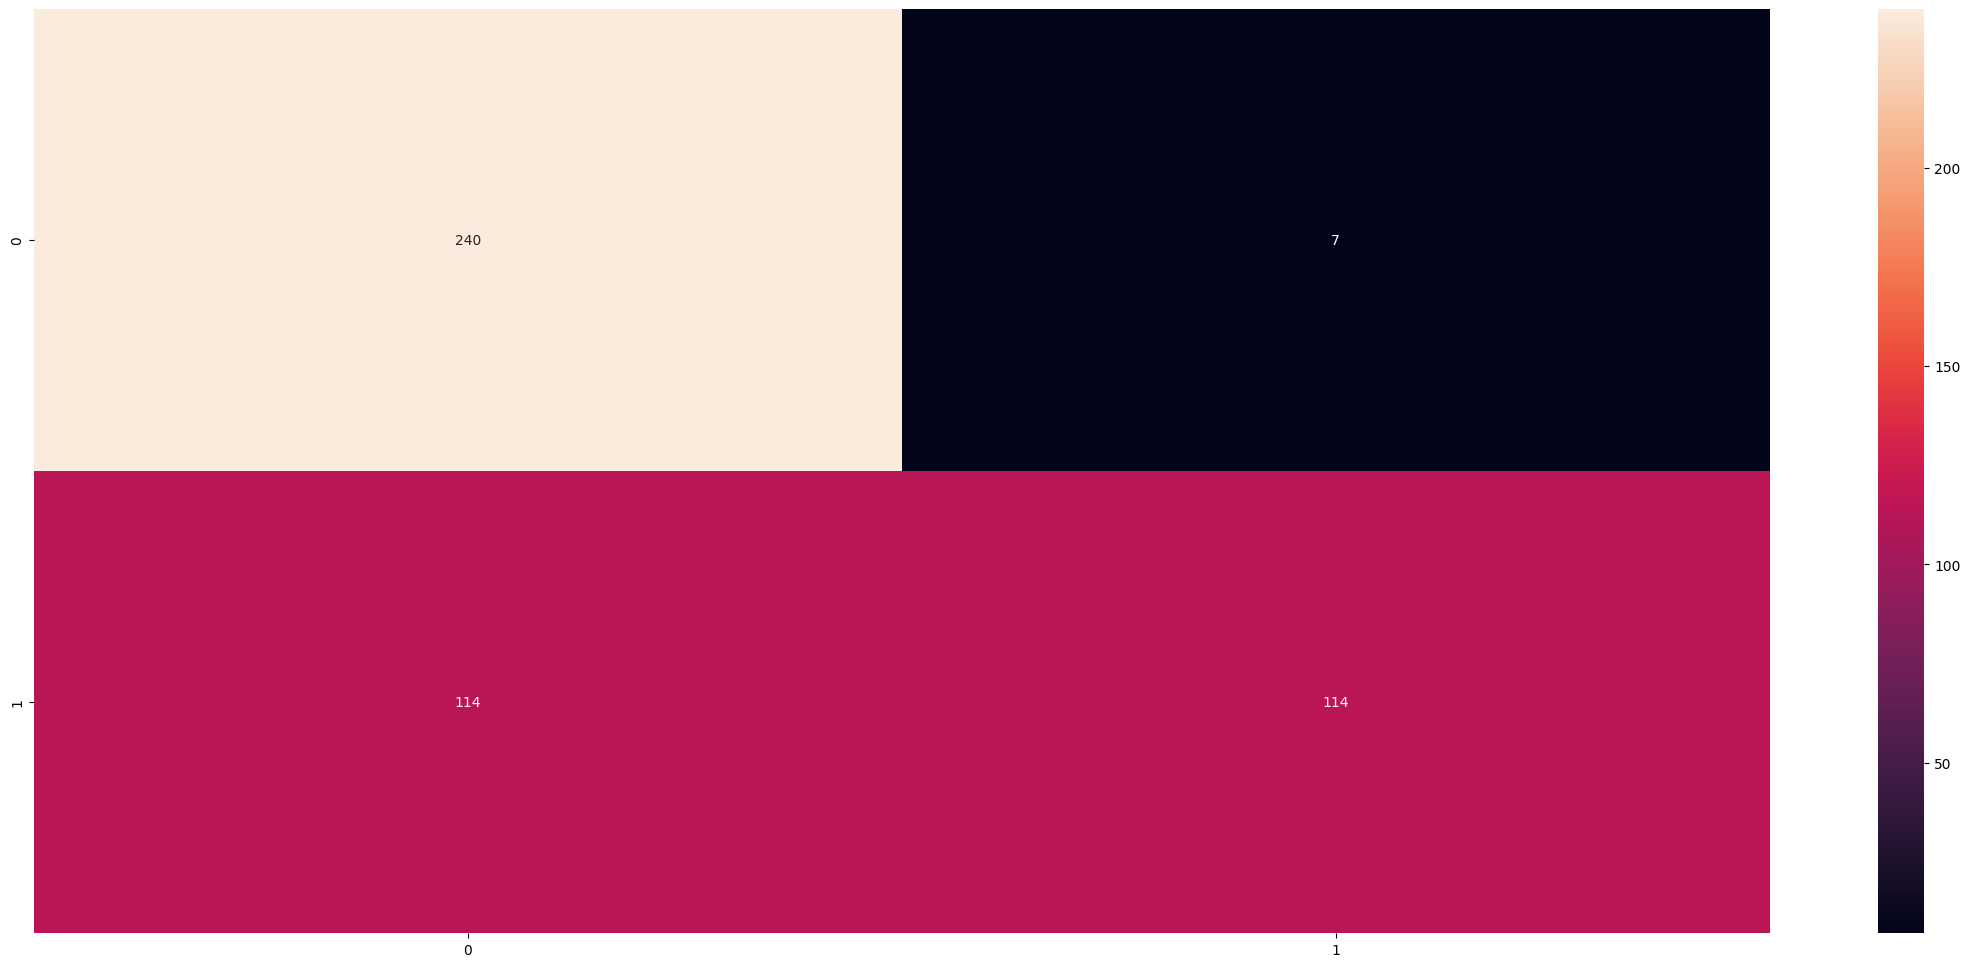

In [274]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

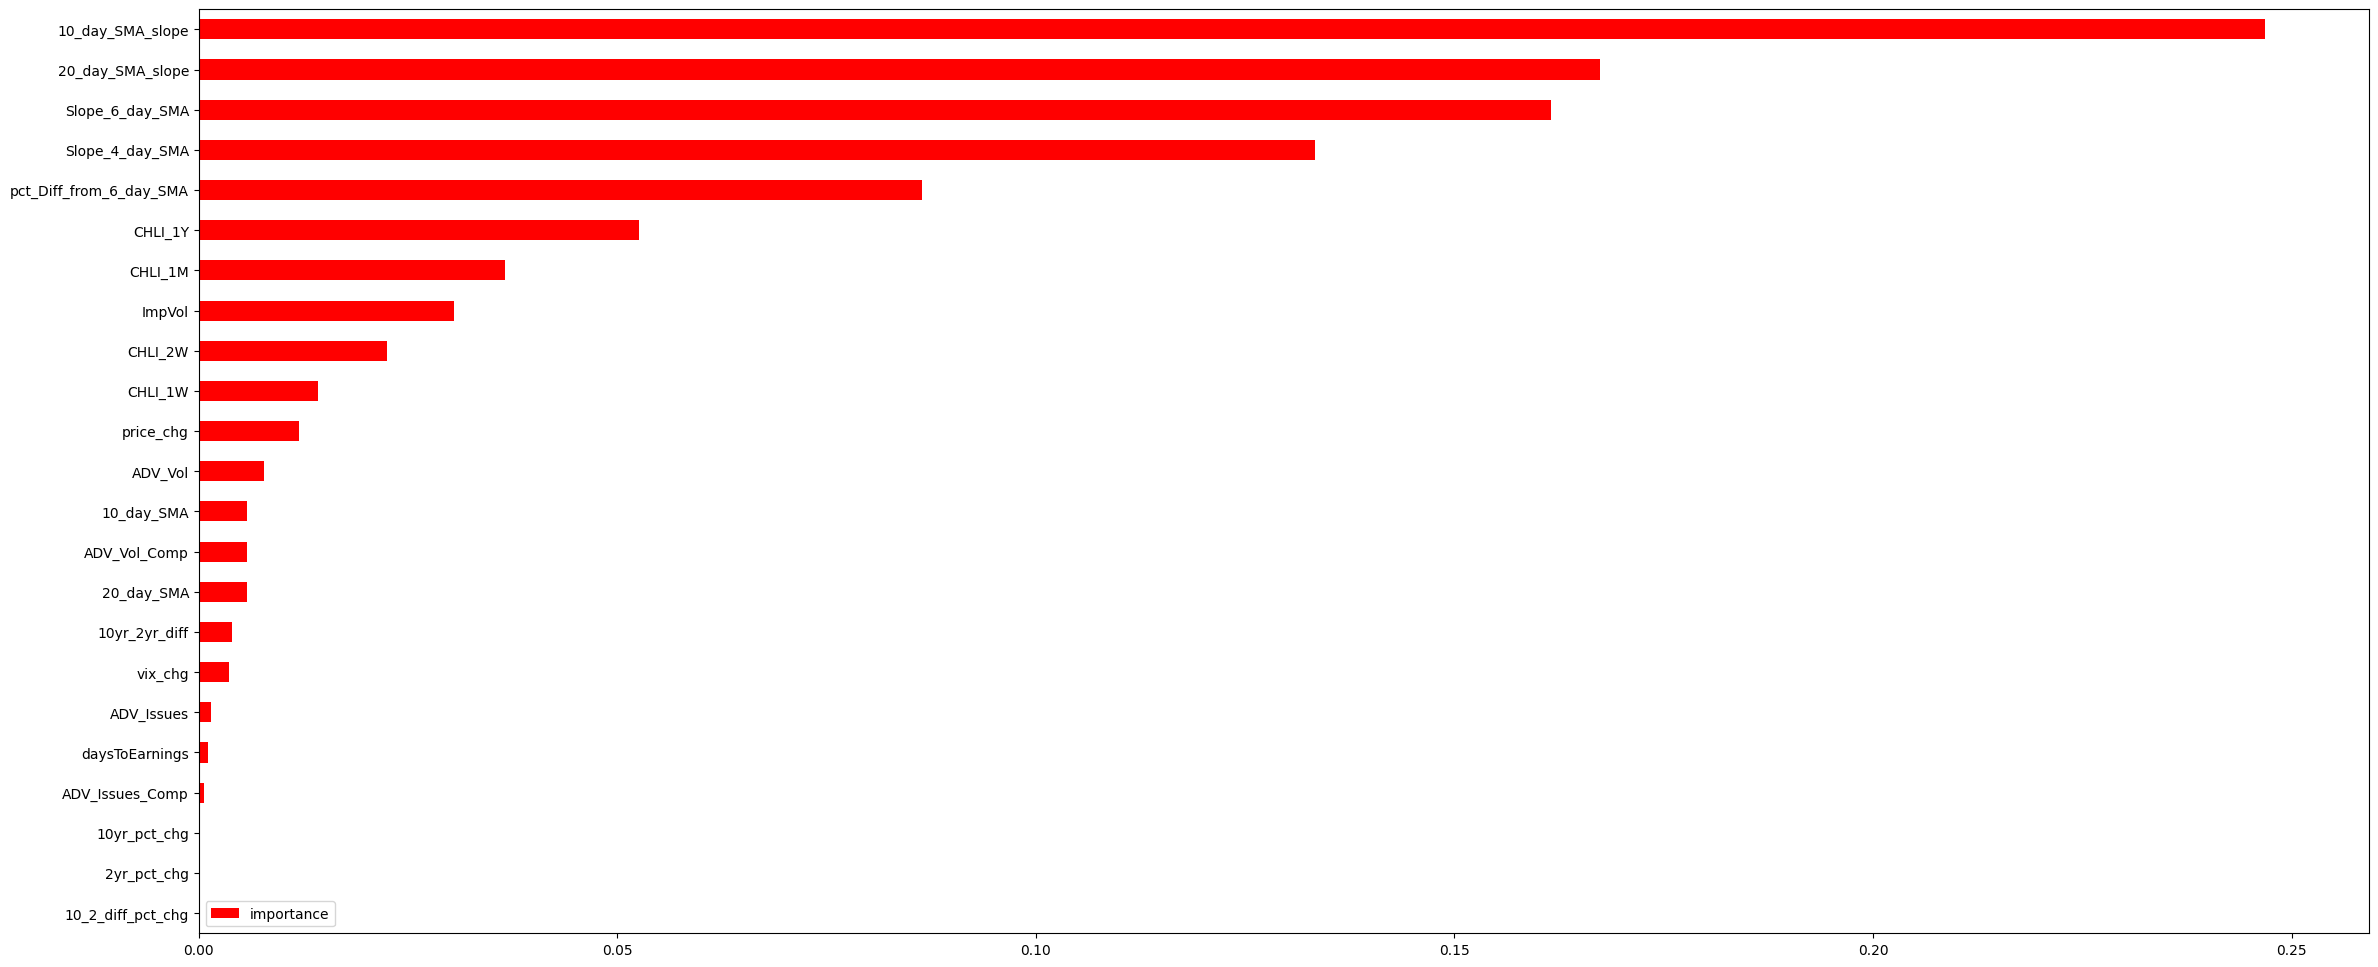

In [275]:

stockutils.plot_feature_importances(X_train=X_train, estimator=rf_gs.best_estimator_)

# PCA 
Out of curiosity, what does affect does running PCA on the data prior to training end up with?

In [276]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler

# yay! this is nice!  now our transform creates a pandas dataframe instead of numpy array
set_config(transform_output="pandas")

pca_scaler = StandardScaler()
pca = PCA(n_components=5)

pipeline = make_pipeline(pca_scaler, pca)

pipeline.fit(X_train)
pca.get_feature_names_out(input_features=X_train.columns)

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4'], dtype=object)

In [277]:
transformed = pca.transform(X_train)
print(transformed.shape)

(1896, 5)


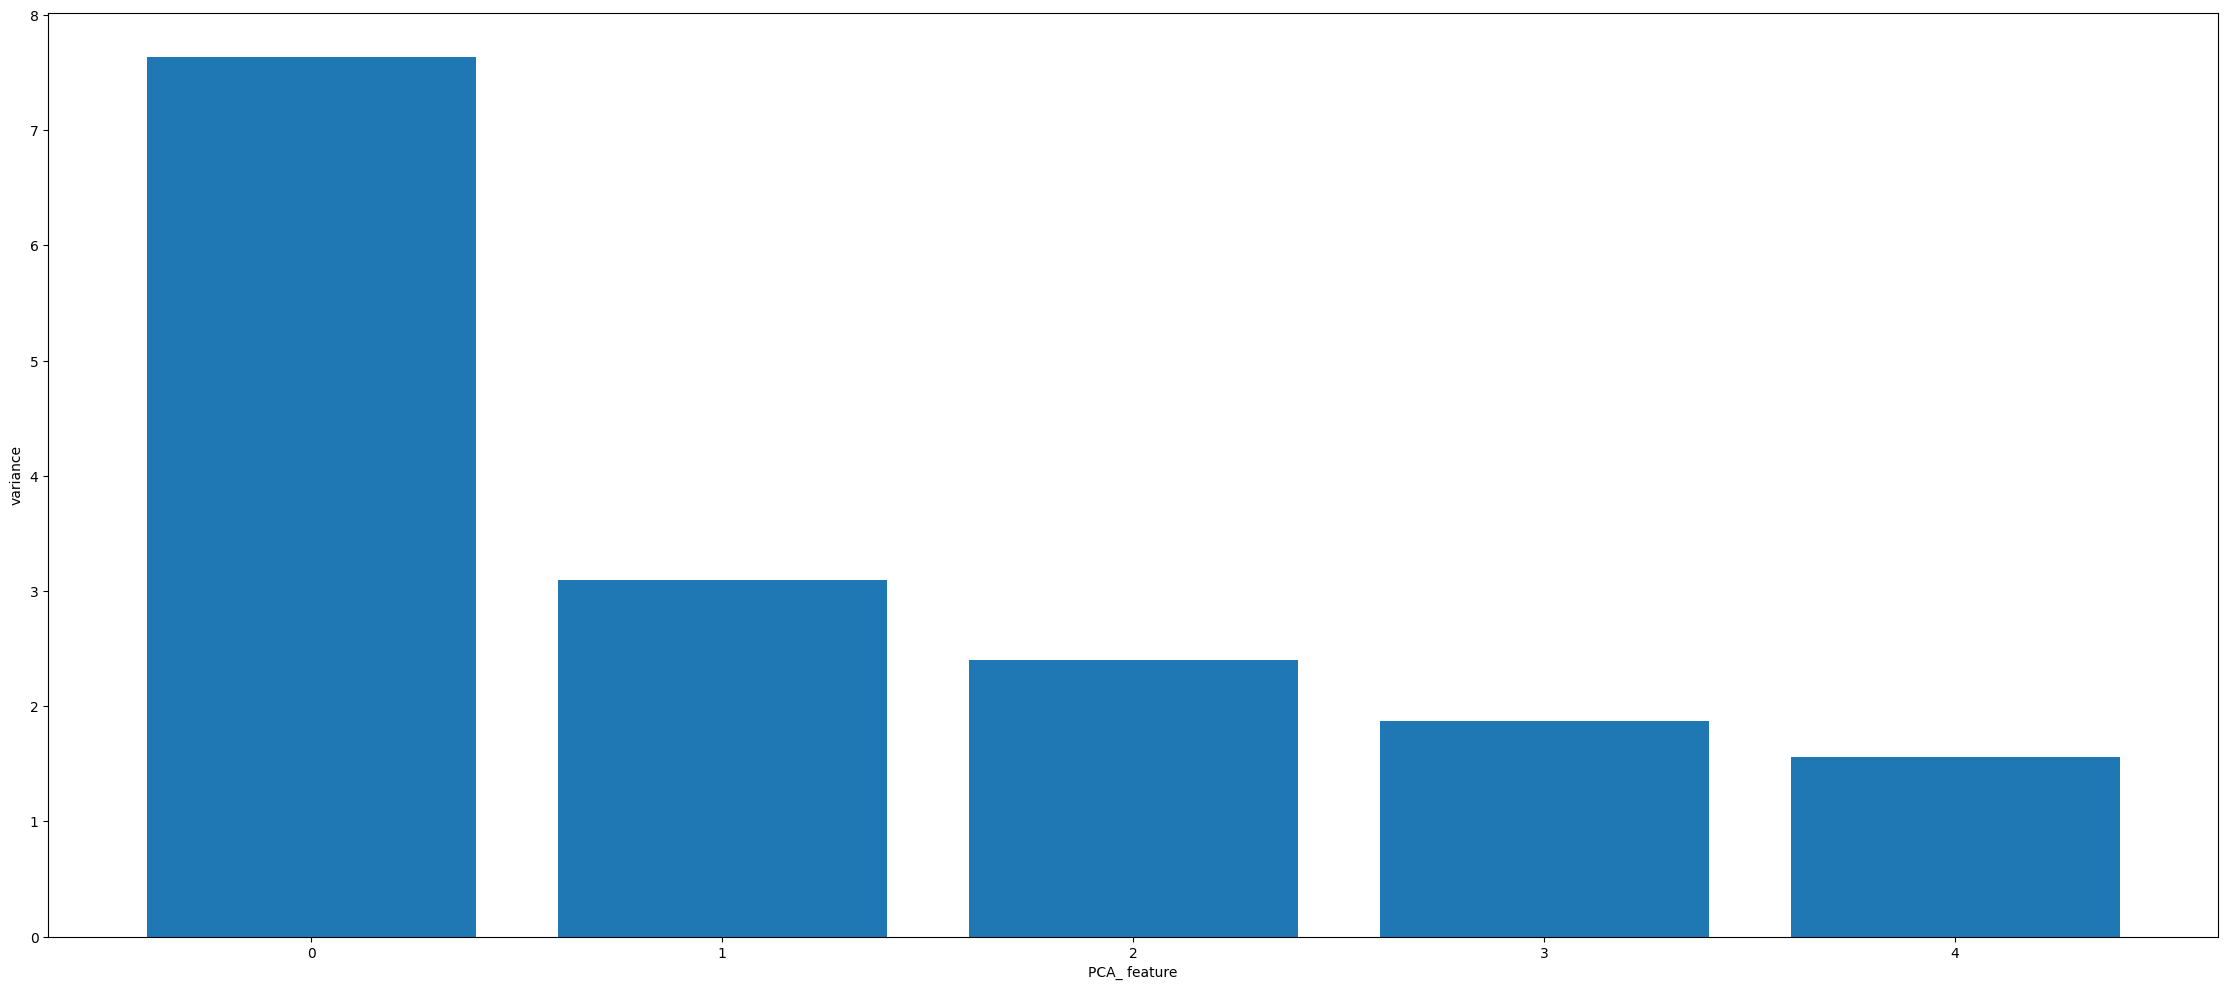

In [278]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA_ feature')
plt.show()

In [279]:
#rf_gs.fit(transformed, y_train)

#y_pred = rf_gs.predict(pca.transform(X_test))

In [280]:
#print("Accuracy: ", accuracy_score(y_test, y_pred))

30%, hmm... that's pretty bad

# XGBoost

In [281]:

#y_train_xgb = pd.Categorical(y_train['Target']).codes
y_train_xgb = pd.Categorical(y_train).codes

#y_test_xgb = pd.Categorical(y_test['Target']).codes
y_test_xgb = pd.Categorical(y_test).codes

In [282]:
import xgboost as xgb

#log to weights and biases
run_name = f"XGBoostBinaryClassifier_{targetName}_{int(time.time())}"
run = wandb.init(entity="christopherandrews", 
                project="StockPredictor", 
                name=run_name, save_code=False, 
                settings=wandb.Settings(start_method="fork"), 
                reinit=True, 
                sync_tensorboard=True,)

tscv = 10

evals = [(X_train, y_train_xgb), (X_test, y_test_xgb)]



cls = xgb.XGBClassifier(objective='binary:logistic',#'multi:softmax', 
                        #num_class=3,
                        n_estimators=500, 
                        seed=42, 
                        importance_type='gain', 
                        device="cuda",
                        early_stopping_rounds=20,
                        eval_metric=['error'],
                        callbacks=[WandbCallback(log_feature_importance=True, importance_type="gain")]
                        ) 
#Base classifier 
cls.fit(X_train, y_train_xgb, eval_set=evals)
y_pred_train_xgb = cls.predict(X_train)
y_pred_test_xgb = cls.predict(X_test)

print("Base classifier training set accuracy:", accuracy_score(y_train_xgb, y_pred_train_xgb))
print("Base classifier test set accuracy:", accuracy_score(y_test_xgb, y_pred_test_xgb))
print("Base classifier params:", cls.get_params())

# alpha is L1 regularization - zeros some weights
#lambda is L2 regularization - smoother penalty
# cls_params = {
#     'learning_rate':[0.001,0.01, 0.1, 0.2, 1, 10],
#     'max_depth':[1,2],
#     'subsample':[ 0.2, 0.5, 0.7, 0.8, 0.9]
# }

cls_params = {
    'n_estimators': [50, 100, 250, 500],
    'learning_rate':[0.001, 0.01, 0.1],
    'max_depth':[2, 4, 6],
    'subsample':[ 0.1, 0.2]
}
xgb_gs = RandomizedSearchCV(cls, param_distributions=cls_params, cv=tscv, scoring='roc_auc', verbose=False)

#xgb_gs = GridSearchCV(cls, param_grid=cls_params, cv=tscv, scoring='accuracy', verbose=False)

xgb_gs.fit(X_train, y_train_xgb, eval_set=evals)

y_pred = xgb_gs.predict(X_test)

run.summary['accuracy'] = accuracy_score(y_test_xgb, y_pred)

writer = SummaryWriter(f"runs/{run_name}")
writer.add_text("hyperparameters",
                "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in xgb_gs.best_params_.items()]))
)

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
xgb_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
xgb_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(xgb_preds, init_value=1000, init_price=xgb_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

print("Test Accuracy: ", accuracy_score(y_test_xgb, y_pred))
print("Best Params", xgb_gs.best_params_)

wandb.sklearn.plot_confusion_matrix(y_test_xgb, y_pred)

run.finish()

[0]	validation_0-error:0.17247	validation_1-error:0.35368
[1]	validation_0-error:0.10918	validation_1-error:0.37263
[2]	validation_0-error:0.08439	validation_1-error:0.35158
[3]	validation_0-error:0.07806	validation_1-error:0.34737
[4]	validation_0-error:0.06435	validation_1-error:0.33684
[5]	validation_0-error:0.05538	validation_1-error:0.32632
[6]	validation_0-error:0.05274	validation_1-error:0.34105
[7]	validation_0-error:0.04536	validation_1-error:0.33263
[8]	validation_0-error:0.03956	validation_1-error:0.33474
[9]	validation_0-error:0.03639	validation_1-error:0.34526
[10]	validation_0-error:0.03586	validation_1-error:0.35368
[11]	validation_0-error:0.03217	validation_1-error:0.34316
[12]	validation_0-error:0.03270	validation_1-error:0.34316
[13]	validation_0-error:0.03006	validation_1-error:0.34316
[14]	validation_0-error:0.02690	validation_1-error:0.34737
[15]	validation_0-error:0.02479	validation_1-error:0.35158
[16]	validation_0-error:0.01899	validation_1-error:0.35789
[17]	va

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 167.57, cash balance: $1095.8200000000002
Buying 6 shares for 170.03. Remaining Balance: 75.6400000000001
Selling all shares for 163.62, cash balance: $1057.3600000000001
Buying 6 shares for 163.43. Remaining Balance: 76.78000000000009
Selling all shares for 153.84, cash balance: $999.82
Buying 6 shares for 146.10. Remaining Balance: 123.22000000000014
Selling all shares for 146.40, cash balance: $1001.6200000000002
Buying 7 shares for 142.41. Remaining Balance: 4.750000000000227
Selling all shares for 143.86, cash balance: $1011.7700000000003
Buying 7 shares for 143.39. Remaining Balance: 8.040000000000418
Selling all shares for 138.88, cash balance: $980.2000000000004
Buying 6 shares for 146.87. Remaining Balance: 98.98000000000036
Selling all shares for 144.22, cash balance: $964.3000000000003
Buying 6 shares for 148.03. Remaining Balance: 76.12000000000023
Selling all shares for 146.63, cash bal

best_iteration,▁▁▁▁▁▂▃▄▂▅▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█▇▃
best_score,▄████▂▂▂▂▁▂▂████████████████████████▂▁▂▁
epoch,▁▂▁▃▂▂▃▅▄▂▂▂▇▄▁▂▂▂▁▂▁▂▁▁▂▂▂▁▁▂▁▆▇▄▃█▂▂▂▃
validation_0-error,███▂▂▂▂▁▂▃▃▃▁▁█▃███████████████▃▂▃▃▂▃▄▃▃
validation_1-error,███▃▃▄▂▃▃▄▂▅▃▃█▃███████████████▁▁▂▂▁▂▄▃▁
Buy And Hold (Base ROI),62.64
Max ROI,2143.55
ROI,526.42
accuracy,0.79579
best_iteration,24
best_score,0.20421


In [283]:
results = xgb_gs.best_estimator_.evals_result()


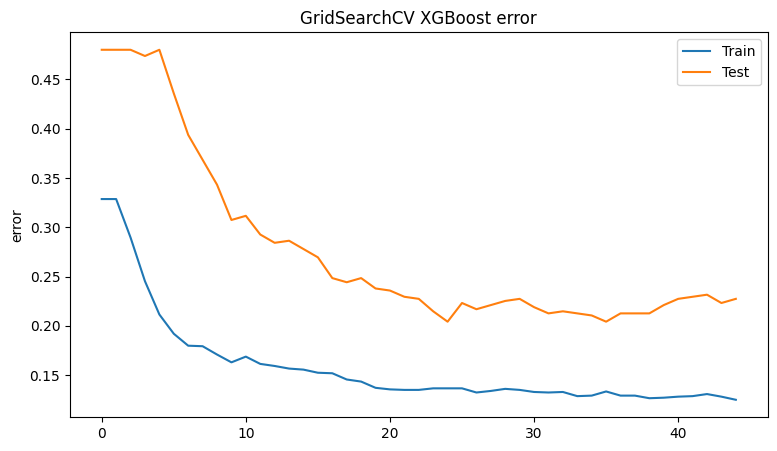

In [284]:
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('GridSearchCV XGBoost error')
plt.show()

# # xgboost 'merror' plot
# fig, ax = plt.subplots(figsize=(9,5))
# ax.plot(x_axis, results['validation_0']['merror'], label='Train')
# ax.plot(x_axis, results['validation_1']['merror'], label='Test')
# ax.legend()
# plt.ylabel('merror')
# plt.title('GridSearchCV XGBoost merror')
# plt.show()

In [285]:
run.finish()

# XGBoost #2 using native API ( DMatrix, etc)

In [286]:
# we will change our main dataset slightly
#stockdf, targetdf, otherdf
from sklearn.preprocessing import OrdinalEncoder


In [287]:
y_train_xgb = pd.Categorical(y_train).codes
y_test_xgb = pd.Categorical(y_test).codes

y_encoded = OrdinalEncoder().fit_transform(targetdf)


#X_train, X_test, y_train, y_test = train_test_split(stockdf,y_encoded, train_size=0.8,shuffle=False)


train_xgb = xgb.DMatrix(X_train, y_train_xgb, enable_categorical=True)

test_xgb = xgb.DMatrix(X_test, y_test_xgb, enable_categorical=True)

In [288]:
y_test

date
7/26/2022    BUY
7/27/2022    BUY
7/28/2022    BUY
7/29/2022    BUY
8/1/2022     BUY
            ... 
6/7/2024     BUY
6/10/2024    BUY
6/11/2024    BUY
6/12/2024    BUY
6/13/2024    BUY
Name: Target, Length: 475, dtype: object

In [289]:
import xgboost as xgb
from wandb.integration.xgboost import WandbCallback

run_name = f"XGBoostBinaryClassNative_{targetName}_{int(time.time())}"
run = wandb.init(entity="christopherandrews", 
                project="StockPredictor", 
                name=run_name, save_code=False, 
                settings=wandb.Settings(start_method="fork"), 
                reinit=True, 
                sync_tensorboard=True,)

params = {"objective": 'multi:softmax'#'binary:logistic'
        , "device":"cuda"
        ,"num_class":2
        , 'max_depth': 3
        , 'learning_rate': 0.001
        , 'random_state': 42
        , 'eval_metric': ['merror']}

# alpha is L1 regularization - zeros some weights
#lambda is L2 regularization - smoother penalty
# params = {
#         "objective": "multi:softprob"
#         , "num_class":3
#         , 'gamma': 1               ## def: 0
#         , 'learning_rate': 0.1     ## def: 0.1
#         , 'max_depth': 3
#         , 'min_child_weight': 100  ## def: 1
#         , 'nthread': 24
#         , 'random_state': 42
#         , 'reg_alpha': 0
#         , 'reg_lambda': 0          ## def: 1
#         , 'eval_metric': ['auc', 'logloss']
#         , "device":"cuda" # use to train on GPU
#     }

evals = [(train_xgb, "train"), (test_xgb, "test")]
num_rounds = 100000

cls2 = xgb.train(params=params, 
                dtrain=train_xgb, 
                num_boost_round=num_rounds, 
                evals=evals, 
                verbose_eval=10, 
                early_stopping_rounds=200, 
                callbacks=[WandbCallback(log_feature_importance=True, importance_type="gain")])

y_pred_test_xgb = cls2.predict(test_xgb, iteration_range=(0, cls2.best_iteration + 1))

run.summary['accuracy'] = accuracy_score(y_test_xgb, np.round(y_pred_test_xgb))
print("Test Accuracy: ", accuracy_score(y_test_xgb, np.round(y_pred_test_xgb)))
xgb_preds = pd.DataFrame(data=y_pred_test_xgb, columns=["Target"], index=y_test.index.copy())
xgb_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bs(xgb_preds, init_value=1000, init_price=xgb_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

wandb.sklearn.plot_confusion_matrix(y_test_xgb, np.round(y_pred_test_xgb))

run.finish()


[0]	train-merror:0.17247	test-merror:0.23579
[10]	train-merror:0.17247	test-merror:0.23579
[20]	train-merror:0.17247	test-merror:0.23579
[30]	train-merror:0.17247	test-merror:0.23579
[40]	train-merror:0.16825	test-merror:0.22737
[50]	train-merror:0.16825	test-merror:0.22737
[60]	train-merror:0.16825	test-merror:0.22737
[70]	train-merror:0.16825	test-merror:0.22737
[80]	train-merror:0.16825	test-merror:0.22737
[90]	train-merror:0.16825	test-merror:0.22737
[100]	train-merror:0.16825	test-merror:0.22526
[110]	train-merror:0.16561	test-merror:0.22526
[120]	train-merror:0.16508	test-merror:0.20421
[130]	train-merror:0.16508	test-merror:0.20632
[140]	train-merror:0.16508	test-merror:0.20632
[150]	train-merror:0.16508	test-merror:0.21053
[160]	train-merror:0.16614	test-merror:0.22316
[170]	train-merror:0.16614	test-merror:0.22737
[180]	train-merror:0.16350	test-merror:0.24632
[190]	train-merror:0.16297	test-merror:0.24632
[200]	train-merror:0.16297	test-merror:0.24632
[210]	train-merror:0.162

best_iteration,▁
best_score,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test-merror,▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▁▁▁▂▂▄▄███████▇▇▇████████
train-merror,█████▆▆▆▆▆▆▆▄▄▄▄▄▄▄▄▄▄▃▃▃▁▂▂▂▂▂▂▄▄▄▄▄▄▄▄
Buy And Hold (Base ROI),62.64
Max ROI,2143.55
ROI,391.87
accuracy,0.79579
best_iteration,117
best_score,0.20421


In [290]:
y_test_xgb

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,

In [291]:
np.round(y_pred_test_xgb)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### show the tree 

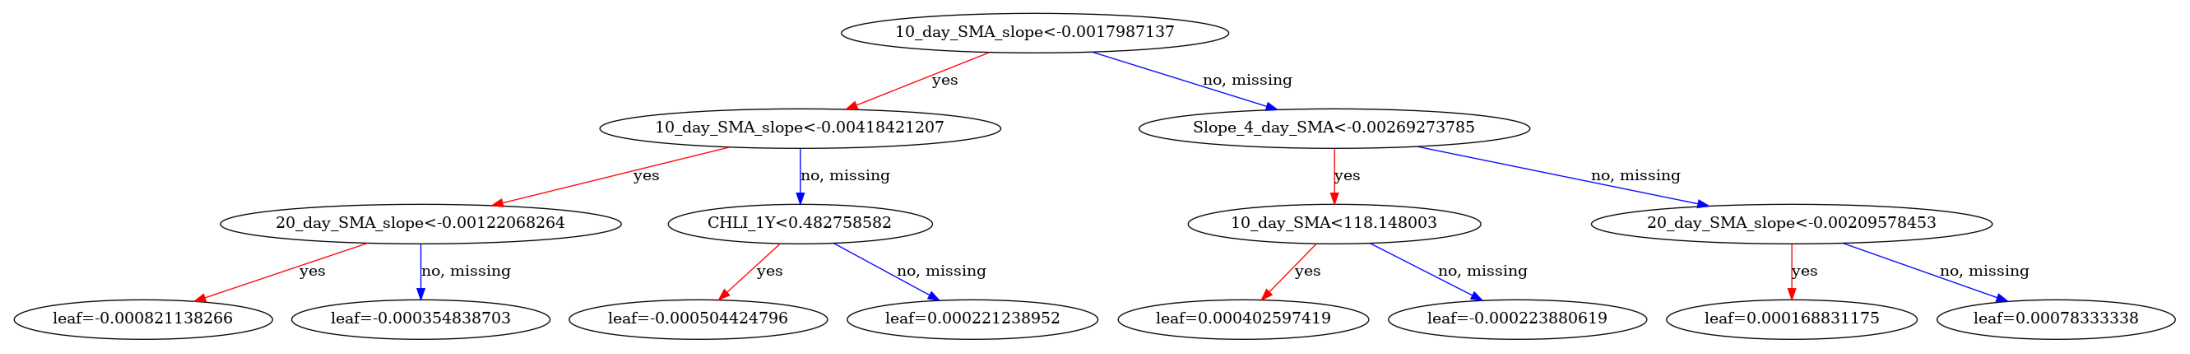

In [292]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 28,12
xgb.plot_tree(cls2)
plt.show()

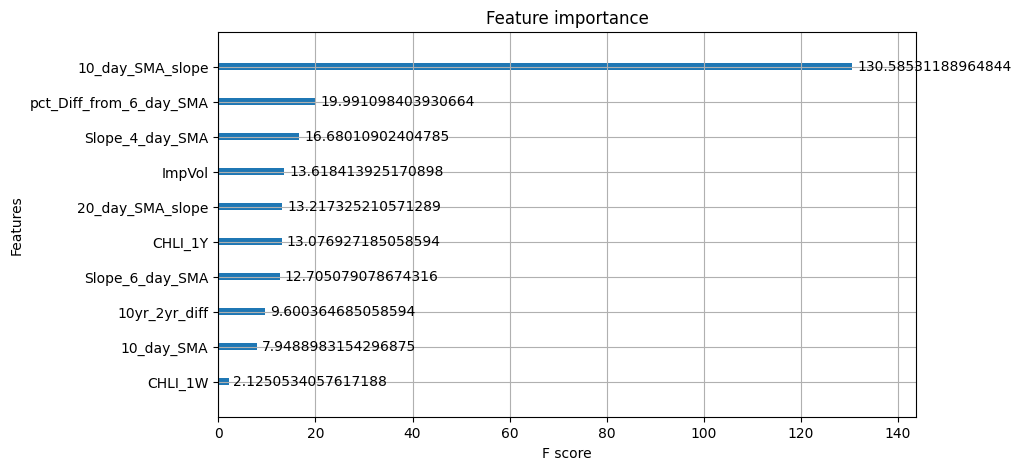

In [293]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(cls2, ax=ax, importance_type="gain")
plt.show()

<Axes: >

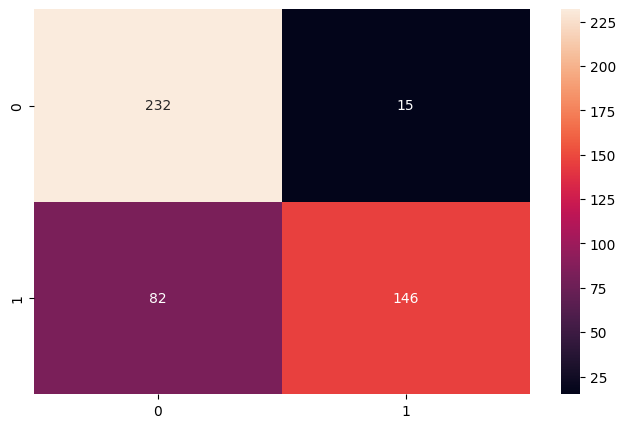

In [294]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test_xgb, y_pred), annot=True, fmt="d")


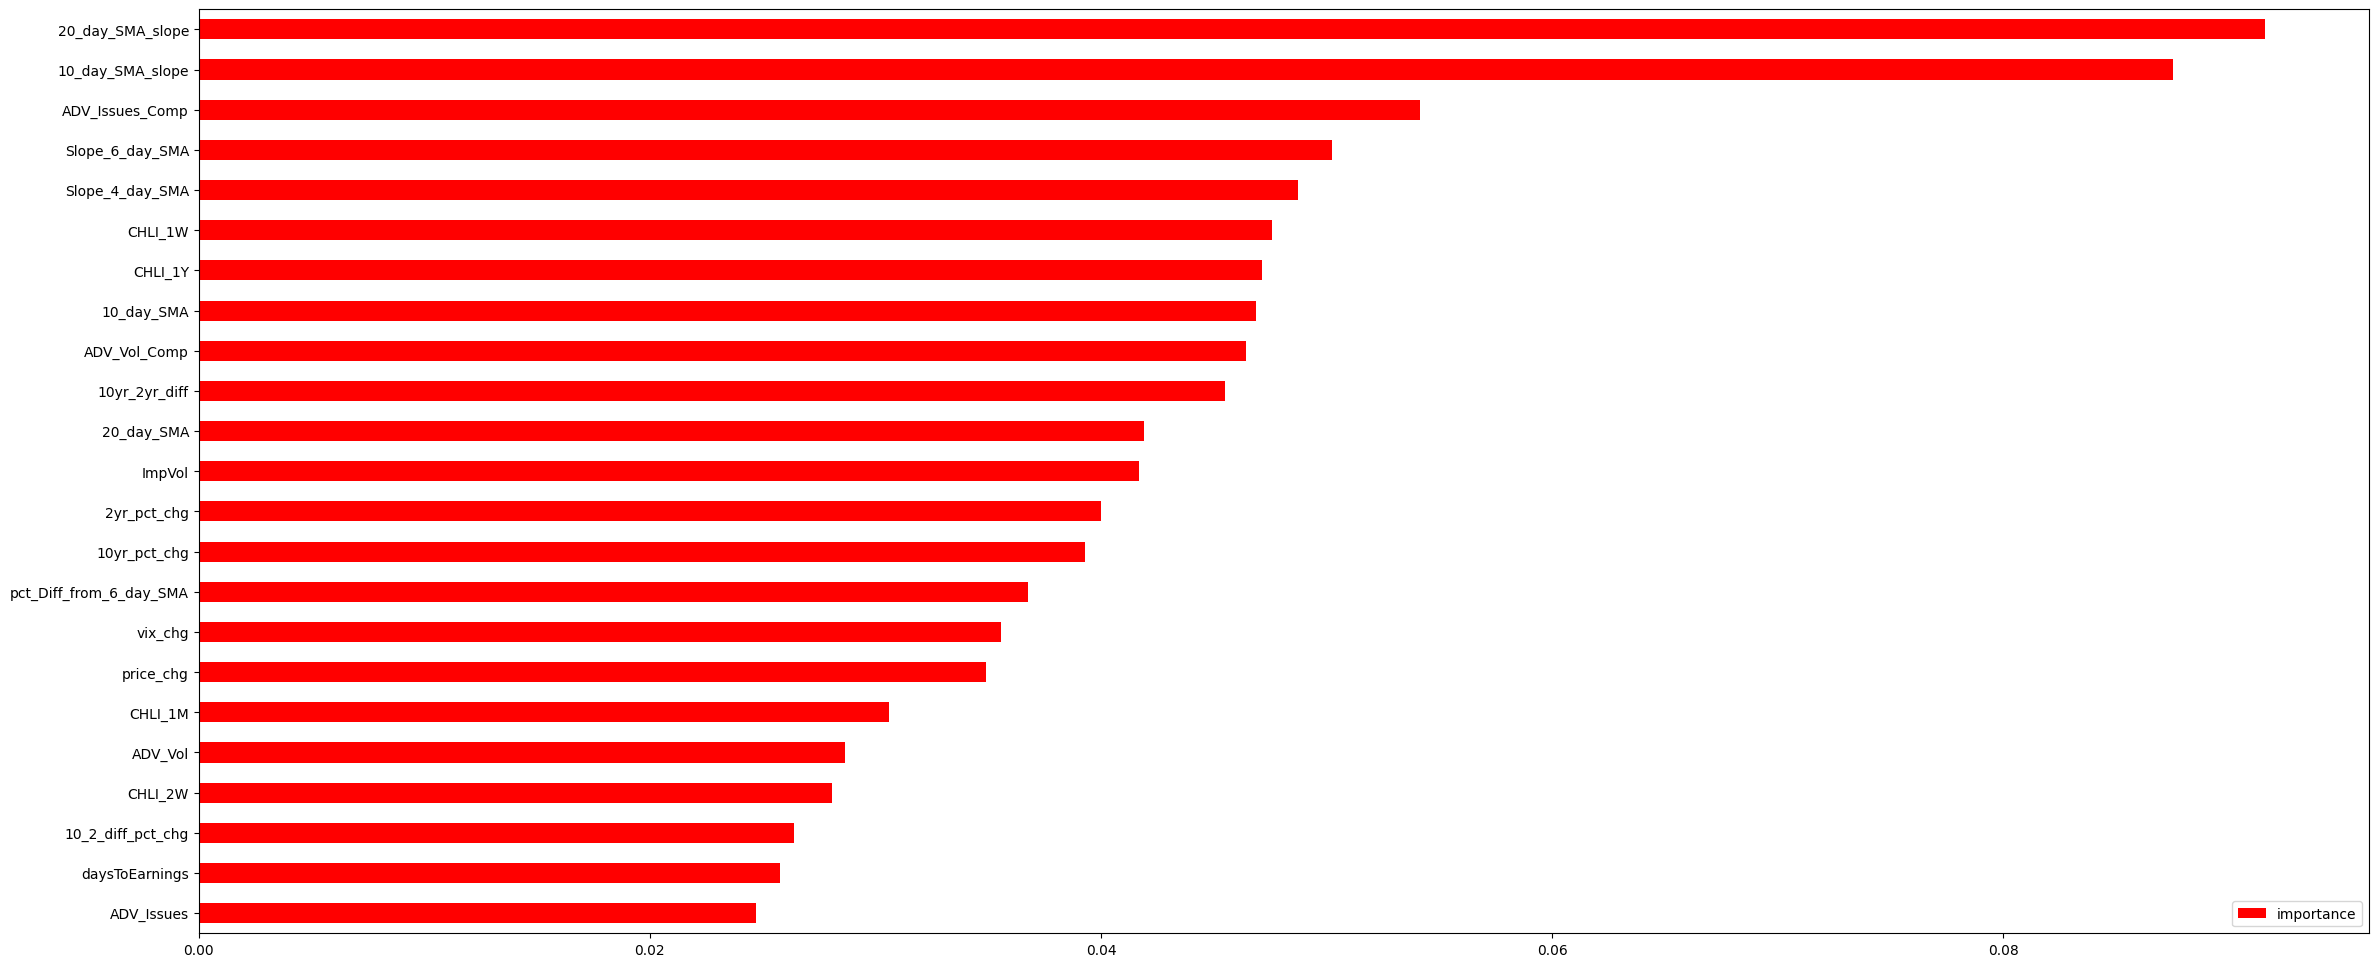

In [295]:
stockutils.plot_feature_importances(X_train=X_train, estimator=xgb_gs.best_estimator_)

XGBoost also has an equivalent feature importance graph

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

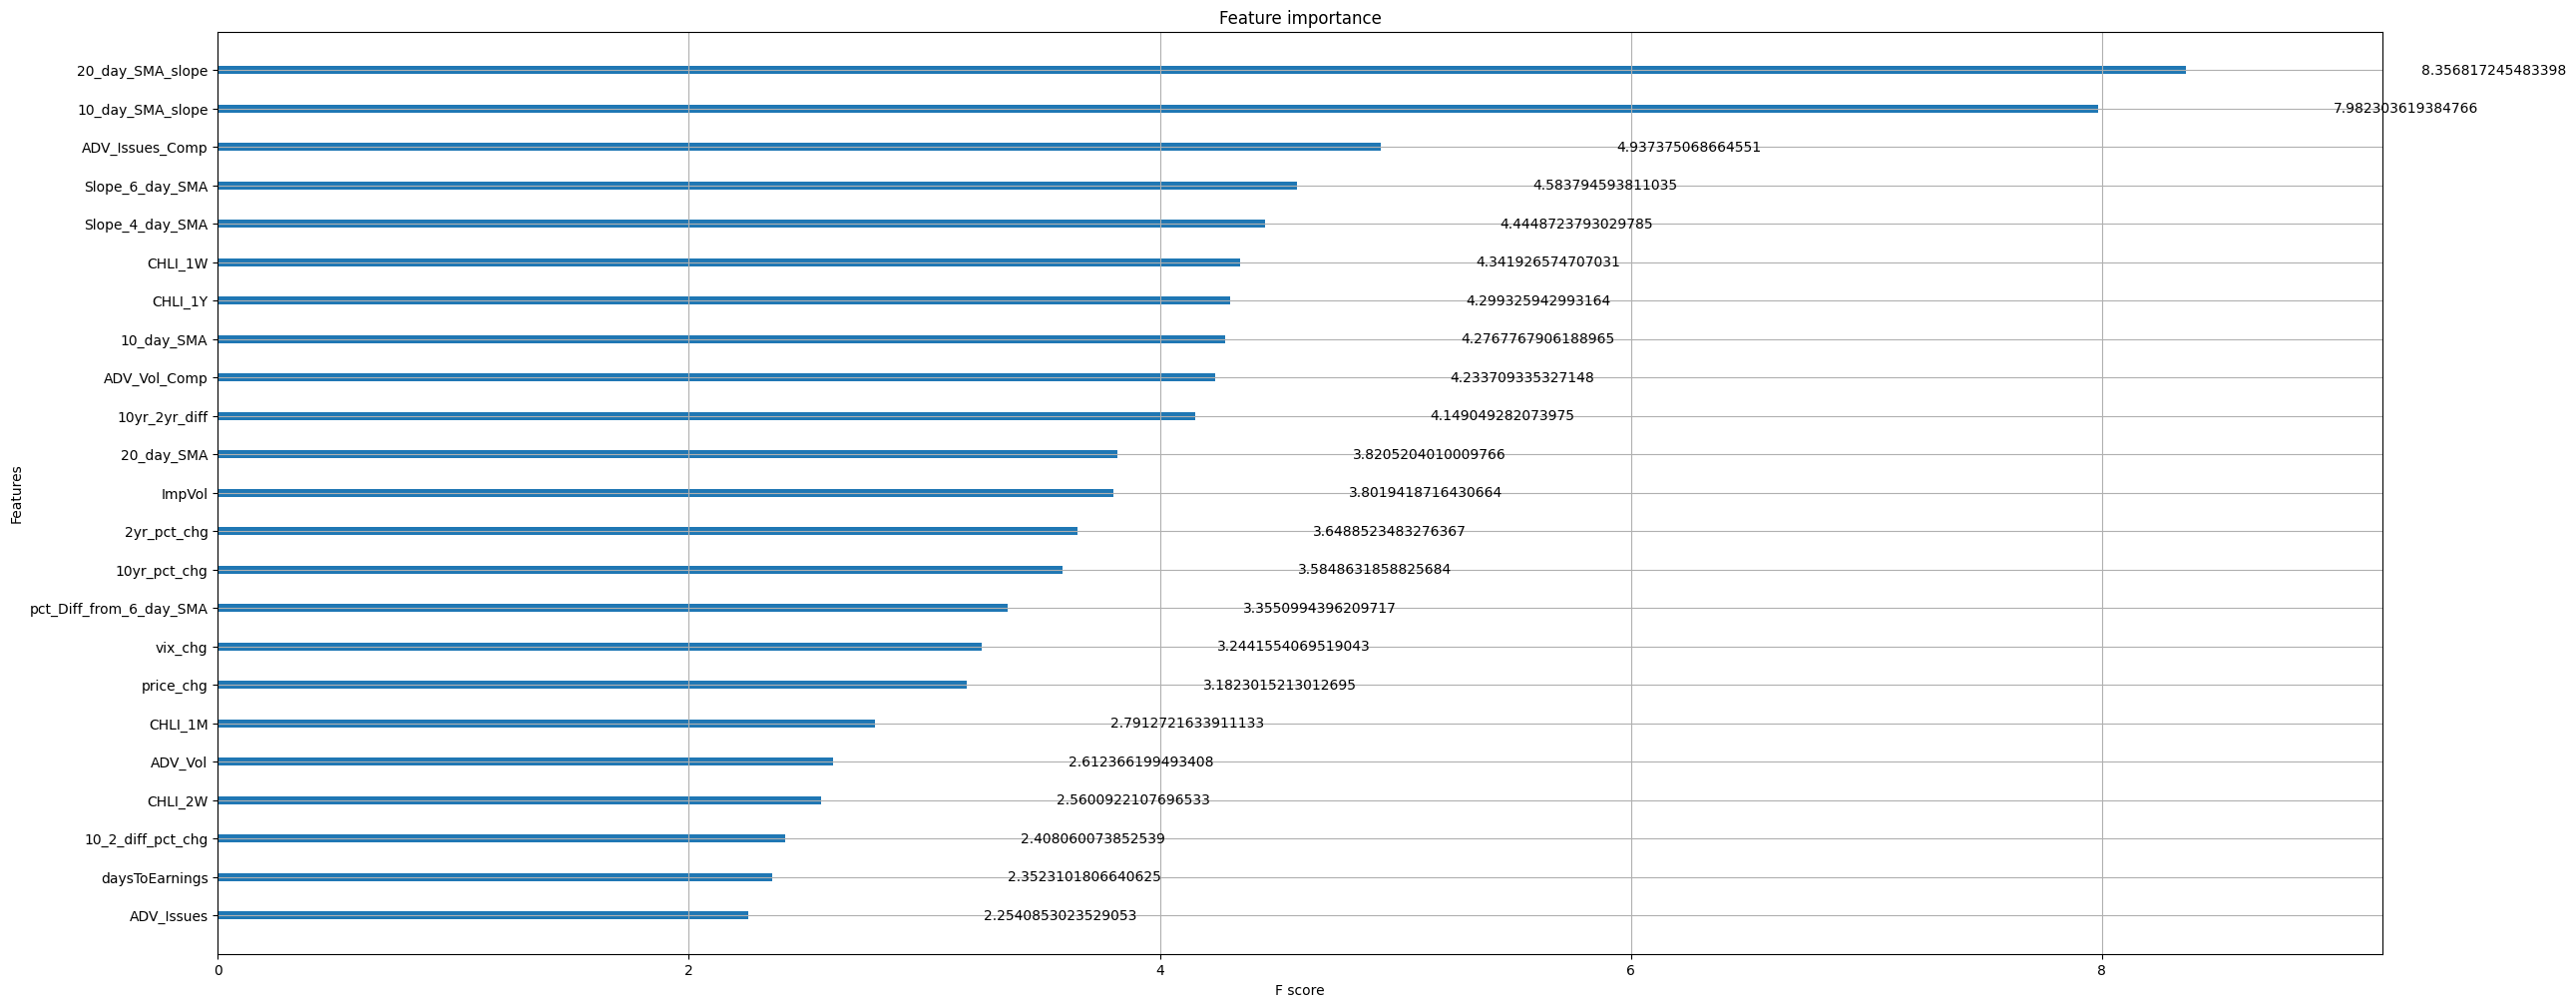

In [296]:
xgb.plot_importance(xgb_gs.best_estimator_, importance_type="gain")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

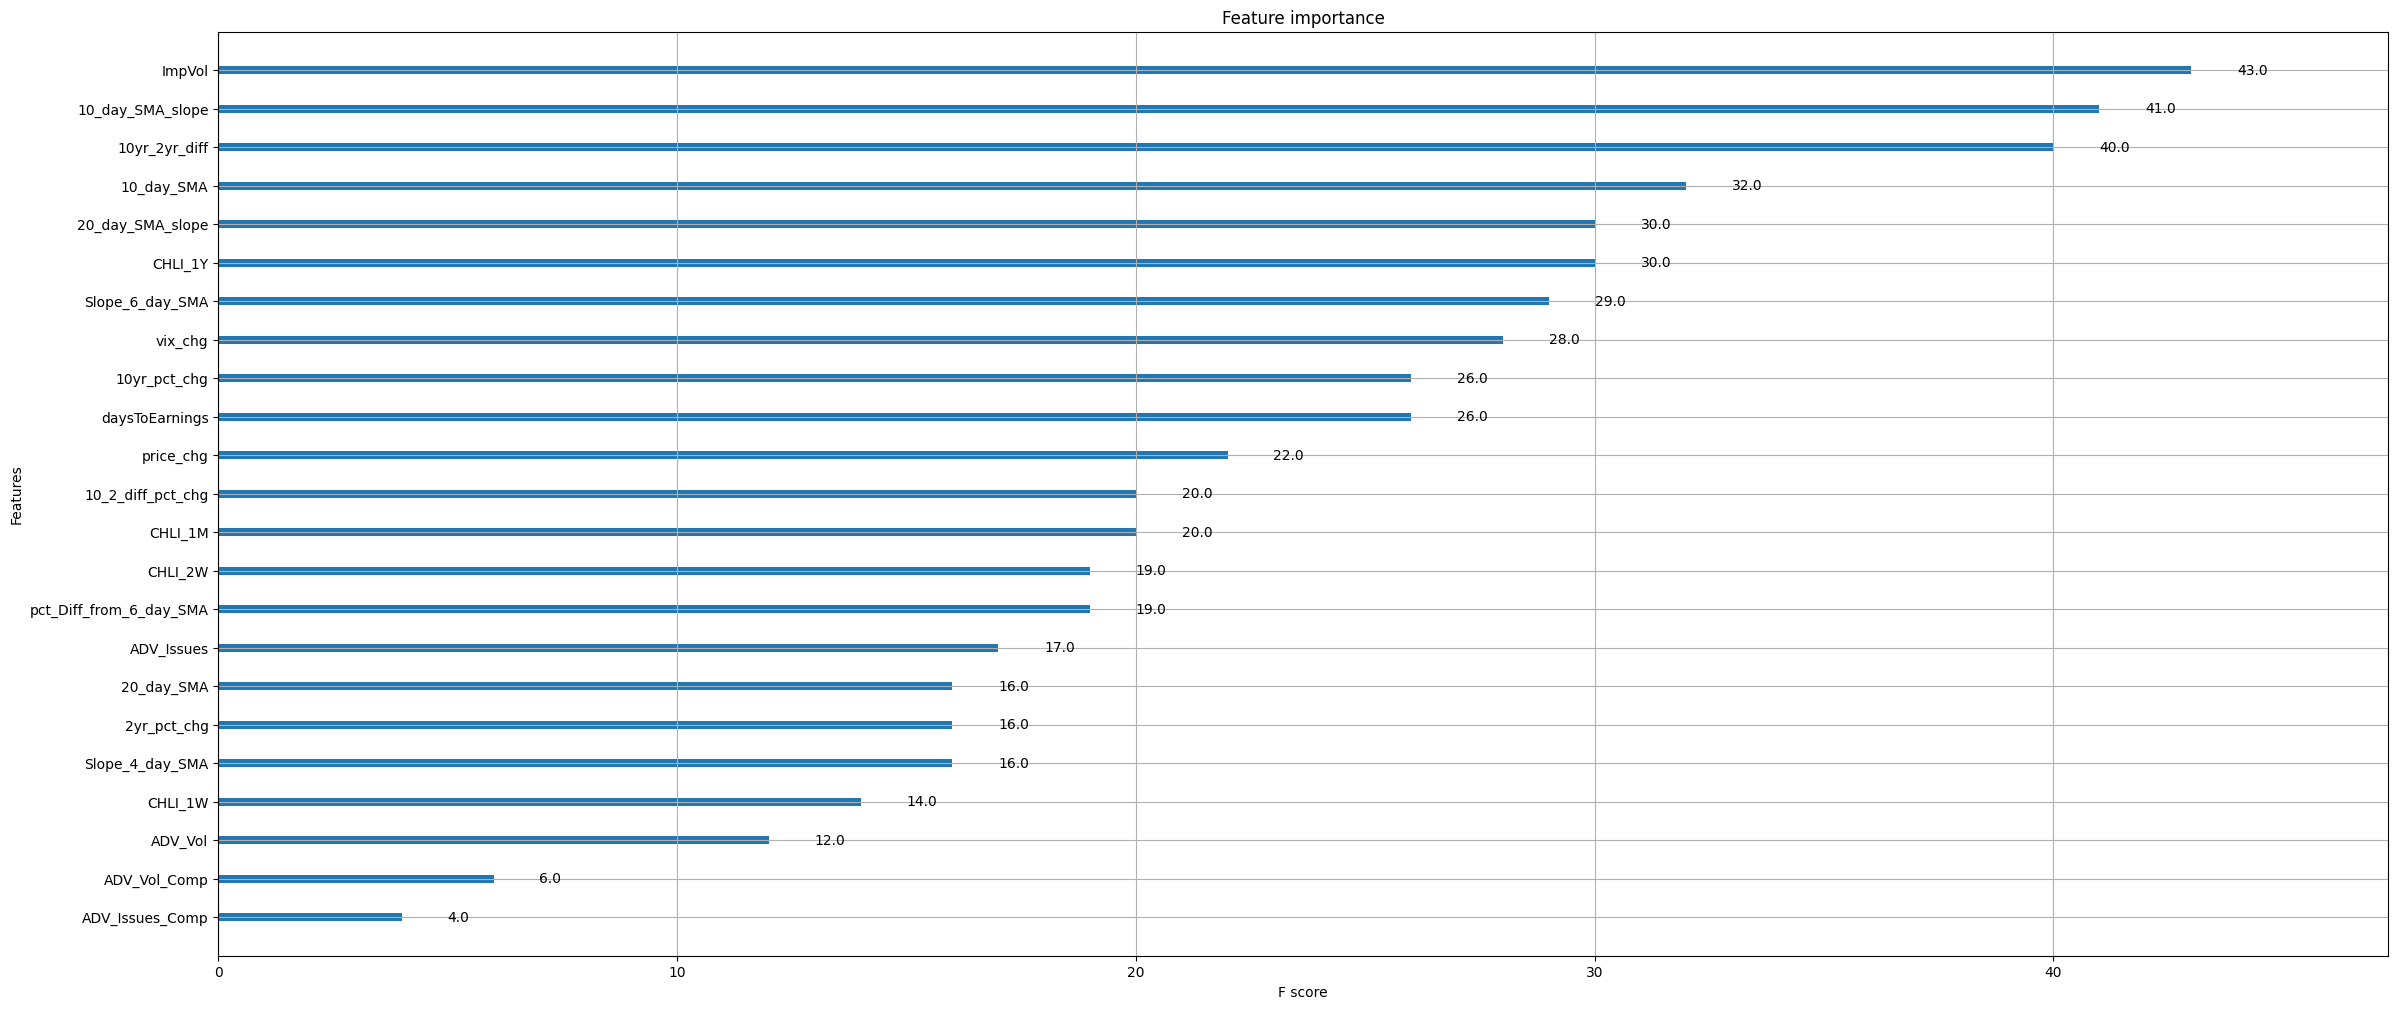

In [297]:
xgb.plot_importance(xgb_gs.best_estimator_)

# How do these models perform on the stock market?  

This won't be quite accurate, (we should use a different stock, or timeframe perhaps) but lets run the model predictions on the full dataset, plot the buys and sells, and then calculate our return

In [298]:
#plop the target value into the otherdf for plotting
otherdf['Target'] = targetdf['Target']

otherdf

,close,vix,2yr_Yield,10yr_Yield,Target
date,,,,,
1/13/2015,27.5550,20.56,0.541,1.905,SELL
1/14/2015,27.4500,21.48,0.501,1.855,SELL
1/15/2015,26.7050,22.39,0.420,1.728,SELL
1/16/2015,26.4975,20.95,0.488,1.831,SELL
1/20/2015,27.1800,19.89,0.499,1.791,BUY
...,...,...,...,...,...
6/7/2024,196.8900,12.22,4.889,4.433,BUY
6/10/2024,193.1200,12.74,4.885,4.471,BUY
6/11/2024,207.1500,12.85,4.834,4.402,BUY


In [299]:
# gather full predictions on the whole dataset
dtc_y_full_pred = dtc_gs.predict(stockdf)
adb_y_full_pred = adb_gs.predict(stockdf)
gbc_y_full_pred = gbc_gs.predict(stockdf)
rf_y_full_pred = rf_gs.predict(stockdf)

xgb_y_full_pred = xgb_gs.predict(stockdf)

#next, our calculate_total_gains requires a dataframe with date index, and 'close' and 'Target' features.


y_full_xgb = pd.Categorical(y_orig).codes
full_xgb = xgb.DMatrix(stockdf, y_full_xgb, enable_categorical=True)
xgb_native_y_full_pred = cls2.predict(full_xgb)


In [300]:
#dtc_y_full_pred

In [301]:
#dtc_y_full_pred = dtc_gs.predict(stockdf)

In [302]:
dtc_predictions = targetdf.copy()
dtc_predictions['Target'] = dtc_y_full_pred
dtc_predictions['close'] = otherdf['close']

adb_predictions = targetdf.copy()
adb_predictions['Target'] = adb_y_full_pred
adb_predictions['close'] = otherdf['close']

gbc_predictions = targetdf.copy()
gbc_predictions['Target'] = gbc_y_full_pred
gbc_predictions['close'] = otherdf['close']

rf_predictions = targetdf.copy()
rf_predictions['Target'] = rf_y_full_pred
rf_predictions['close'] = otherdf['close']

xgb_predictions = targetdf.copy()
xgb_predictions['Target'] = xgb_y_full_pred
xgb_predictions['close'] = otherdf['close']

xgb_native_predictions = targetdf.copy()
xgb_native_predictions['Target'] = xgb_native_y_full_pred
xgb_native_predictions['close'] = otherdf['close']





In [303]:
import math

def calculate_total_gains(df, init_value, init_price, transaction_cost_fixed=0.0  ):
    price = init_price
    num_shares_owned = 0
    gain = 0.0
    cash_balance = init_value
    for idx, row in df.iterrows():
        price = df.loc[idx,'close']#price + (price * row['price_change_pct'])
        if row["Target"] == 'BUY' or row['Target'] == 0:
            max_shares = math.floor(cash_balance/price)
            if max_shares > 0:
                num_shares_owned += max_shares
                cash_balance = cash_balance - (max_shares*price)
                print("Buying {} shares for {:0.2f}. Remaining Balance: {}".format(max_shares, price, cash_balance))
        elif row["Target"] == 'SELL' or row['Target']== 2:
            cash_balance = cash_balance + (num_shares_owned * price)
            if num_shares_owned != 0:
                print("Selling all shares for {:0.2f}, cash balance: ${}".format(price, cash_balance))
            num_shares_owned = 0
    #sell at the end for gain calculation if we are holding stock
    cash_balance = cash_balance + (num_shares_owned * price)   
    print("Selling all remaining held shares, cash balance: ${} ***********************".format(cash_balance))
    roi = cash_balance - init_value
    return roi

In [304]:
initial_investment = 1000

### Buy and Hold

In [305]:
# Buy and hold performance
starting_price = otherdf['close'][0]
ending_price = otherdf['close'][-1]
print("Starting price:", starting_price)
print("Ending price:", ending_price)
num_shares = math.floor(initial_investment/starting_price)
gain = num_shares*ending_price
gain

Starting price: 27.555
Ending price: 214.24


7712.64

### Ideal

In [306]:
# ideal performance


calculate_total_gains(otherdf, init_value=initial_investment, init_price=otherdf['close'][0])

Buying 36 shares for 27.18. Remaining Balance: 21.519999999999982
Selling all shares for 32.41, cash balance: $1188.1
Buying 42 shares for 27.70. Remaining Balance: 24.909999999999854
Selling all shares for 30.30, cash balance: $1297.3
Buying 55 shares for 23.50. Remaining Balance: 4.9375
Selling all shares for 28.01, cash balance: $1545.4875000000002
Buying 68 shares for 22.63. Remaining Balance: 6.647500000000264
Selling all shares for 24.91, cash balance: $1700.1875000000002
Buying 72 shares for 23.40. Remaining Balance: 15.56750000000011
Selling all shares for 29.41, cash balance: $2133.2675000000004
Buying 79 shares for 26.78. Remaining Balance: 17.845000000000255
Selling all shares for 38.84, cash balance: $3086.4025
Buying 85 shares for 36.05. Remaining Balance: 22.577499999999873
Selling all shares for 40.84, cash balance: $3493.765
Buying 91 shares for 38.28. Remaining Balance: 9.830000000000382
Selling all shares for 44.77, cash balance: $4084.3550000000005
Buying 104 shares 

374926.8574999999

### Decision Tree Performance

In [307]:

#Decision Tree Classifier
calculate_total_gains(dtc_predictions, init_value=initial_investment, init_price=dtc_predictions['close'][0])

Buying 36 shares for 27.55. Remaining Balance: 8.019999999999982
Selling all shares for 27.45, cash balance: $996.2199999999999
Buying 36 shares for 27.18. Remaining Balance: 17.739999999999895
Selling all shares for 31.13, cash balance: $1138.33
Buying 36 shares for 31.11. Remaining Balance: 18.279999999999973
Selling all shares for 31.25, cash balance: $1143.3700000000001
Buying 35 shares for 31.91. Remaining Balance: 26.695000000000164
Selling all shares for 31.13, cash balance: $1116.3325000000002
Buying 35 shares for 31.36. Remaining Balance: 18.86550000000011
Selling all shares for 30.64, cash balance: $1091.353
Buying 35 shares for 30.82. Remaining Balance: 12.65300000000002
Selling all shares for 30.69, cash balance: $1086.8905
Buying 35 shares for 30.32. Remaining Balance: 25.515499999999975
Selling all shares for 29.61, cash balance: $1061.8654999999999
Buying 36 shares for 29.29. Remaining Balance: 7.425499999999829
Selling all shares for 28.16, cash balance: $1021.275499999

Selling all shares for 24.34, cash balance: $906.1529999999997
Buying 37 shares for 24.29. Remaining Balance: 7.60799999999972
Selling all shares for 23.83, cash balance: $889.4104999999997
Buying 37 shares for 23.89. Remaining Balance: 5.572999999999752
Selling all shares for 23.35, cash balance: $869.5229999999998
Buying 36 shares for 23.60. Remaining Balance: 19.922999999999774
Selling all shares for 28.62, cash balance: $1050.2429999999997
Buying 37 shares for 27.72. Remaining Balance: 24.602999999999838
Selling all shares for 35.26, cash balance: $1329.3155
Buying 37 shares for 35.46. Remaining Balance: 17.38799999999992
Selling all shares for 36.35, cash balance: $1362.523
Buying 37 shares for 36.59. Remaining Balance: 8.877999999999929
Selling all shares for 38.35, cash balance: $1427.7354999999998
Buying 37 shares for 38.28. Remaining Balance: 11.190499999999929
Selling all shares for 42.25, cash balance: $1574.533
Buying 37 shares for 42.33. Remaining Balance: 8.32299999999986

6620.8254999999945

Pretty poor ROI compared to perfect, but better than buy and hold

<Axes: xlabel='date', ylabel='close'>

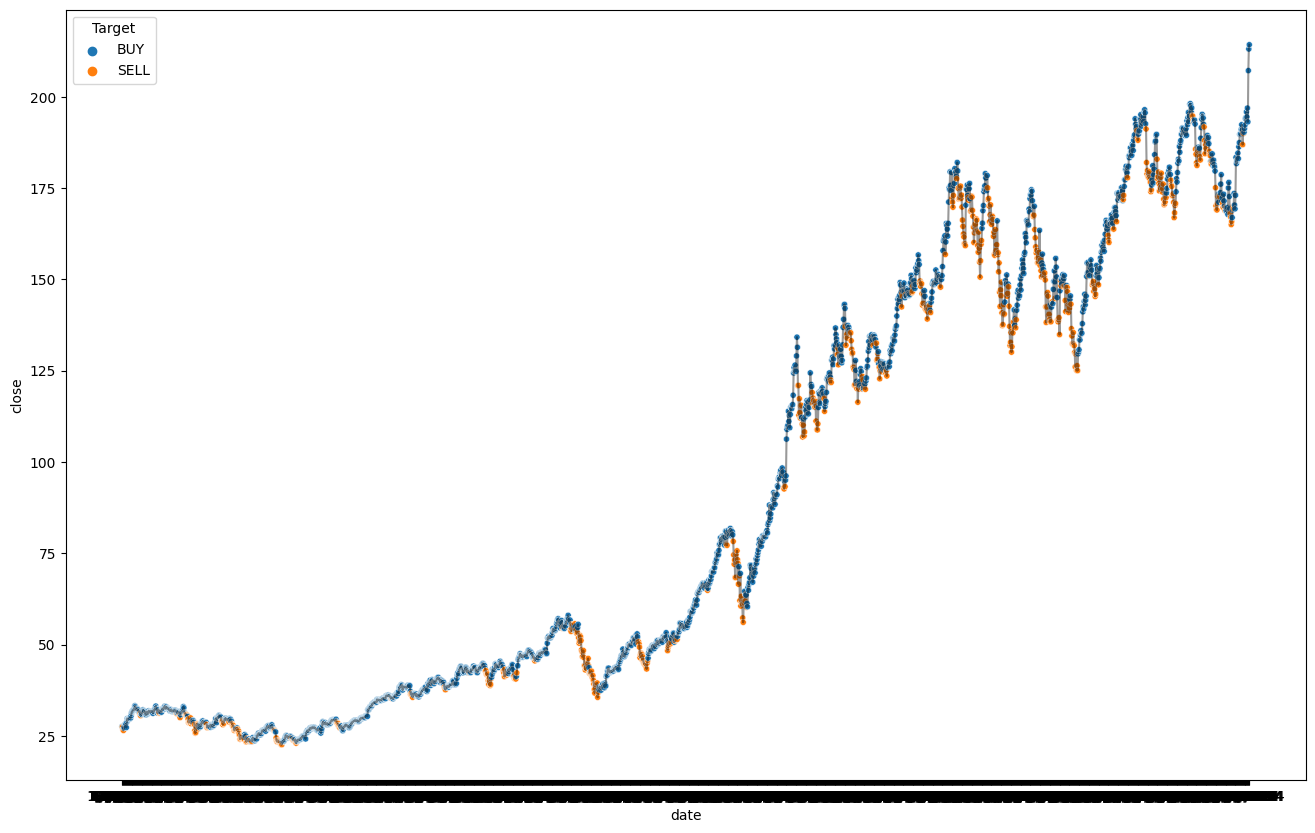

In [308]:

#test_full['price'] = X_test_orig['close'].to_numpy()
#pred_full['price'] = X_test_orig['close'].to_numpy()
#test_full.head()

a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=dtc_predictions, x=dtc_predictions.index, y='close', hue='Target',s=20)

#sns.scatterplot(data=otherdf, x=otherdf.index, y='close', hue='Target', size=0.1 )

### AdaBoost Performance

In [309]:
#AdaBoost Model
calculate_total_gains(adb_predictions, init_value=initial_investment, init_price=adb_predictions['close'][0])

Buying 36 shares for 27.18. Remaining Balance: 21.519999999999982
Selling all shares for 31.65, cash balance: $1160.9199999999998
Buying 36 shares for 32.12. Remaining Balance: 4.689999999999827
Selling all shares for 31.11, cash balance: $1124.56
Buying 35 shares for 31.33. Remaining Balance: 28.00999999999999
Selling all shares for 31.25, cash balance: $1121.8475
Buying 34 shares for 32.24. Remaining Balance: 25.772500000000264
Selling all shares for 32.16, cash balance: $1119.2975000000004
Buying 35 shares for 31.86. Remaining Balance: 4.3725000000004
Selling all shares for 32.22, cash balance: $1132.0725000000004
Buying 35 shares for 31.97. Remaining Balance: 13.1225000000004
Selling all shares for 31.13, cash balance: $1102.7600000000004
Buying 35 shares for 31.36. Remaining Balance: 5.293000000000347
Selling all shares for 30.64, cash balance: $1077.7805000000003
Buying 34 shares for 31.41. Remaining Balance: 9.670500000000402
Selling all shares for 30.69, cash balance: $1053.215

9551.908000000007

<Axes: xlabel='date', ylabel='close'>

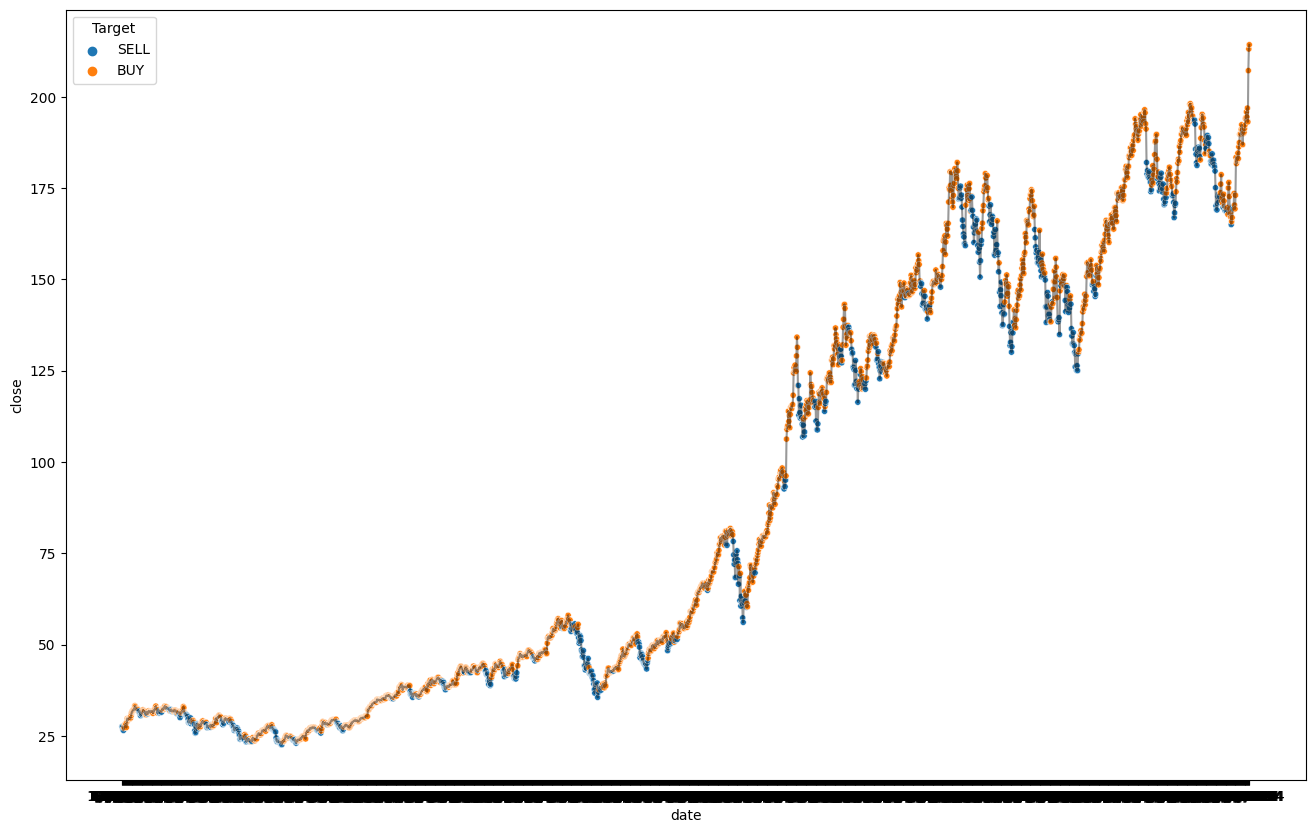

In [310]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=adb_predictions, x=adb_predictions.index, y='close', hue='Target',s=20)

### Gradient Boost Performance

In [311]:
#Gradient Boost
calculate_total_gains(gbc_predictions, init_value=initial_investment, init_price=gbc_predictions['close'][0])

Buying 36 shares for 27.55. Remaining Balance: 8.019999999999982
Selling all shares for 26.50, cash balance: $961.93
Buying 35 shares for 27.18. Remaining Balance: 10.629999999999995
Selling all shares for 31.13, cash balance: $1100.0925000000002
Buying 35 shares for 30.90. Remaining Balance: 18.680000000000064
Selling all shares for 30.02, cash balance: $1069.2925
Buying 34 shares for 30.82. Remaining Balance: 21.41249999999991
Selling all shares for 30.69, cash balance: $1064.9575
Buying 36 shares for 29.29. Remaining Balance: 10.517499999999927
Selling all shares for 28.16, cash balance: $1024.3674999999998
Buying 36 shares for 28.23. Remaining Balance: 8.087499999999864
Selling all shares for 28.32, cash balance: $1027.6974999999998
Buying 37 shares for 27.32. Remaining Balance: 16.949999999999818
Selling all shares for 27.27, cash balance: $1025.7549999999999
Buying 37 shares for 27.70. Remaining Balance: 1.0399999999999636
Selling all shares for 27.38, cash balance: $1013.915
Buy

6819.7825

<Axes: xlabel='date', ylabel='close'>

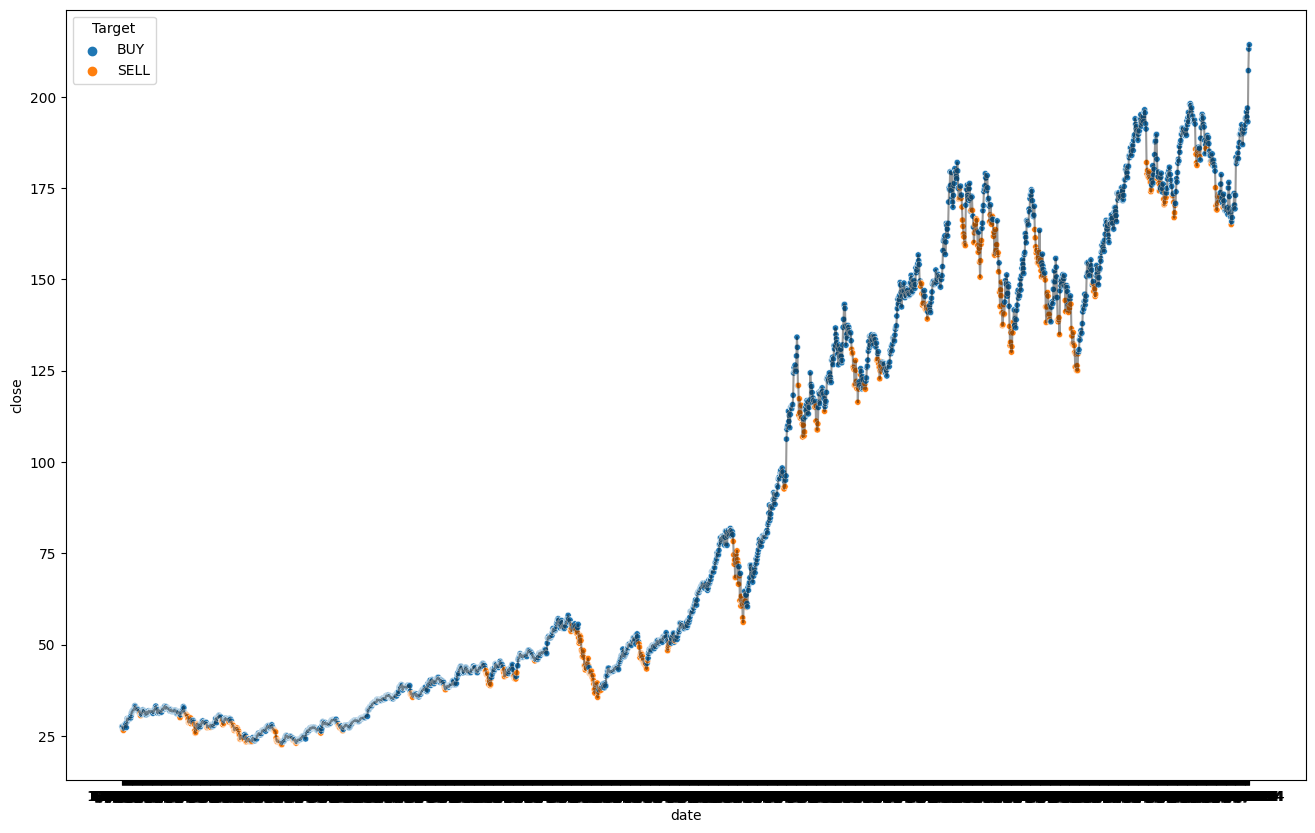

In [312]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=gbc_predictions, x=gbc_predictions.index, y='close', hue='Target',s=20)

### Random Forest Performance

In [313]:
calculate_total_gains(rf_predictions, init_value=initial_investment, init_price=rf_predictions['close'][0])

Buying 36 shares for 27.55. Remaining Balance: 8.019999999999982
Selling all shares for 27.45, cash balance: $996.2199999999999
Buying 36 shares for 27.18. Remaining Balance: 17.739999999999895
Selling all shares for 31.13, cash balance: $1138.33
Buying 36 shares for 31.11. Remaining Balance: 18.279999999999973
Selling all shares for 30.84, cash balance: $1128.7
Buying 35 shares for 31.59. Remaining Balance: 22.96250000000009
Selling all shares for 31.29, cash balance: $1118.025
Buying 34 shares for 32.24. Remaining Balance: 21.950000000000273
Selling all shares for 31.45, cash balance: $1091.2500000000002
Buying 34 shares for 31.91. Remaining Balance: 6.480000000000246
Selling all shares for 31.13, cash balance: $1064.9850000000004
Buying 33 shares for 31.36. Remaining Balance: 30.230400000000373
Selling all shares for 30.64, cash balance: $1041.4329000000002
Buying 33 shares for 31.41. Remaining Balance: 4.737900000000309
Selling all shares for 31.12, cash balance: $1031.862900000000

5664.922899999999

<Axes: xlabel='date', ylabel='close'>

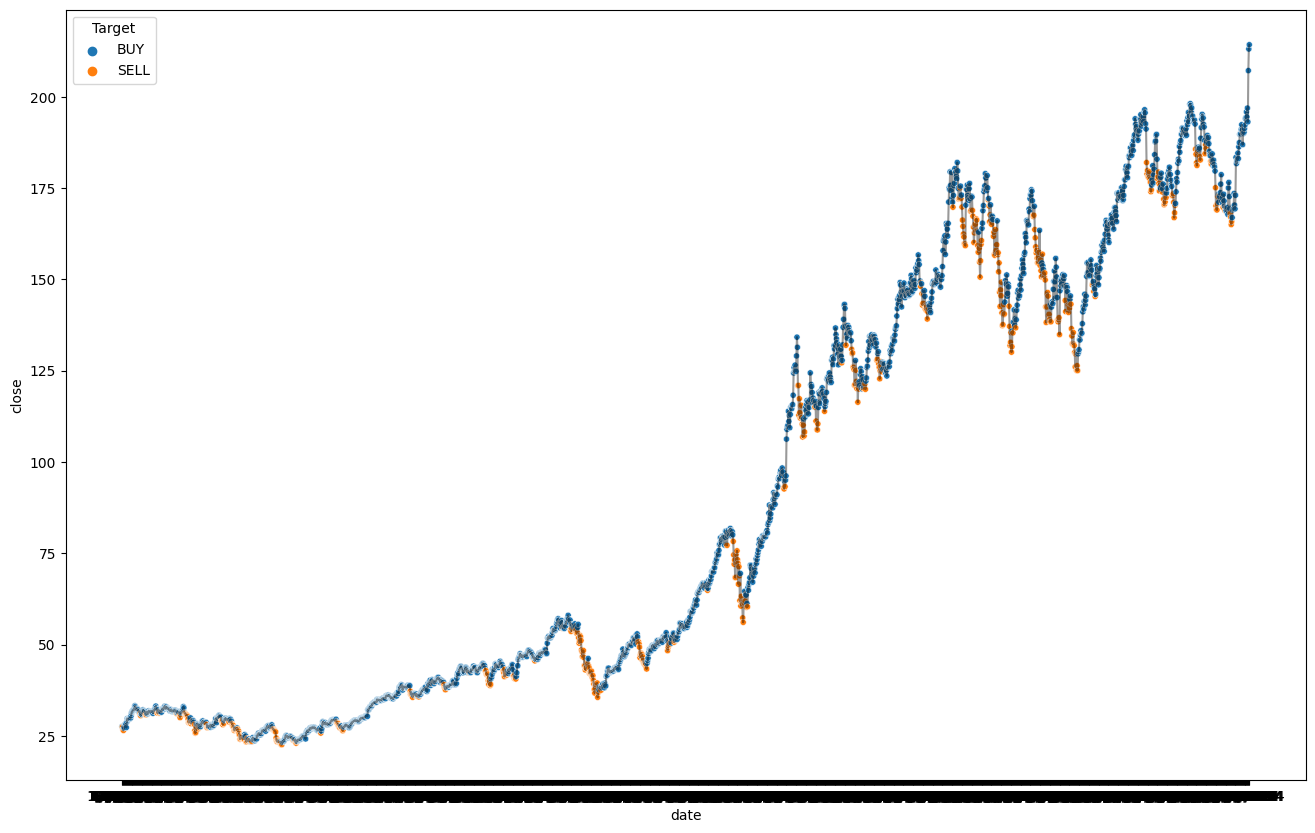

In [314]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=rf_predictions, x=rf_predictions.index, y='close', hue='Target',s=20)

### XGBoost Performance

In [315]:
calculate_total_gains(xgb_predictions, init_value=initial_investment, init_price=xgb_predictions['close'][0])

Buying 36 shares for 27.55. Remaining Balance: 8.019999999999982
Selling all remaining held shares, cash balance: $7720.66 ***********************


6720.66

<Axes: xlabel='date', ylabel='close'>

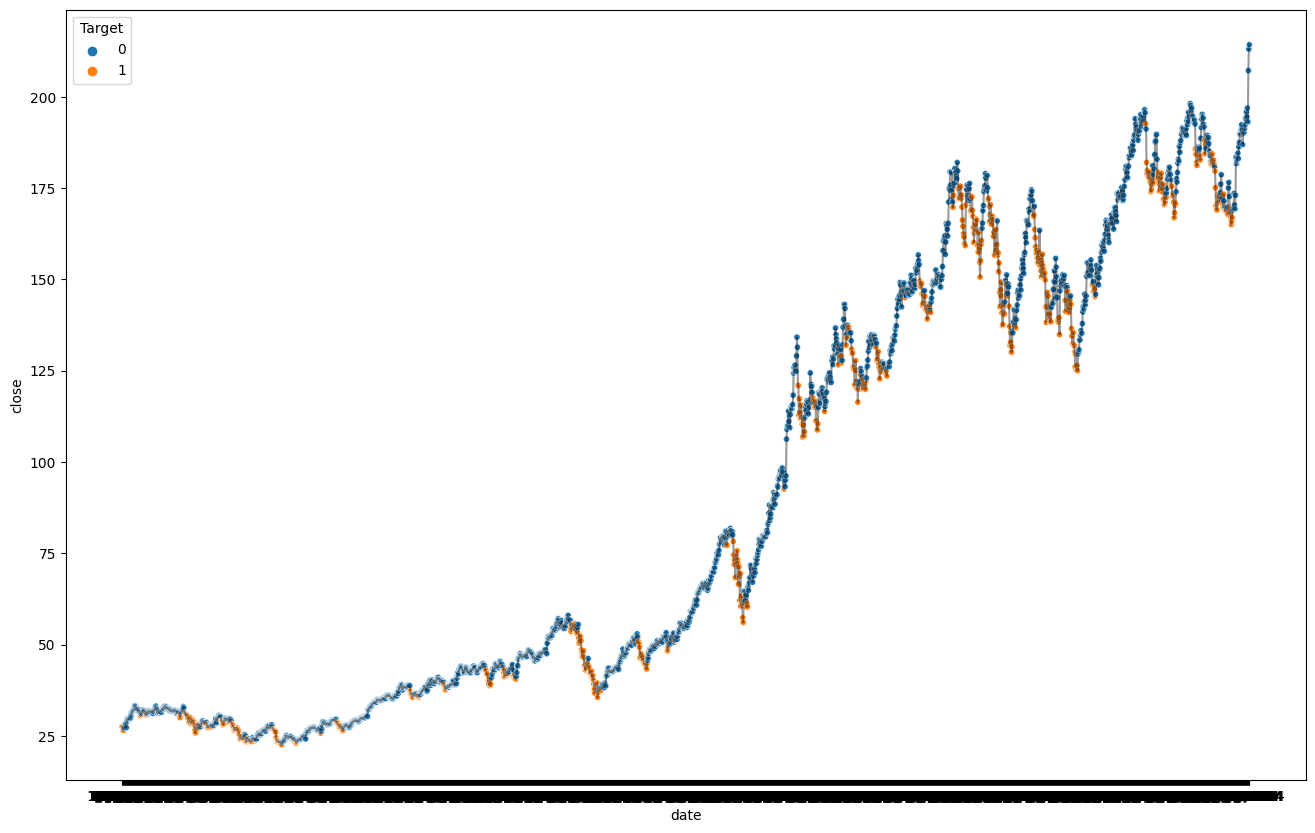

In [316]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=xgb_predictions, x=xgb_predictions.index, y='close', hue='Target',s=20)

In [317]:
calculate_total_gains(xgb_native_predictions, init_value=initial_investment, init_price=xgb_native_predictions['close'][0])

Buying 36 shares for 27.18. Remaining Balance: 21.519999999999982
Selling all remaining held shares, cash balance: $7734.16 ***********************


6734.16

<Axes: xlabel='date', ylabel='close'>

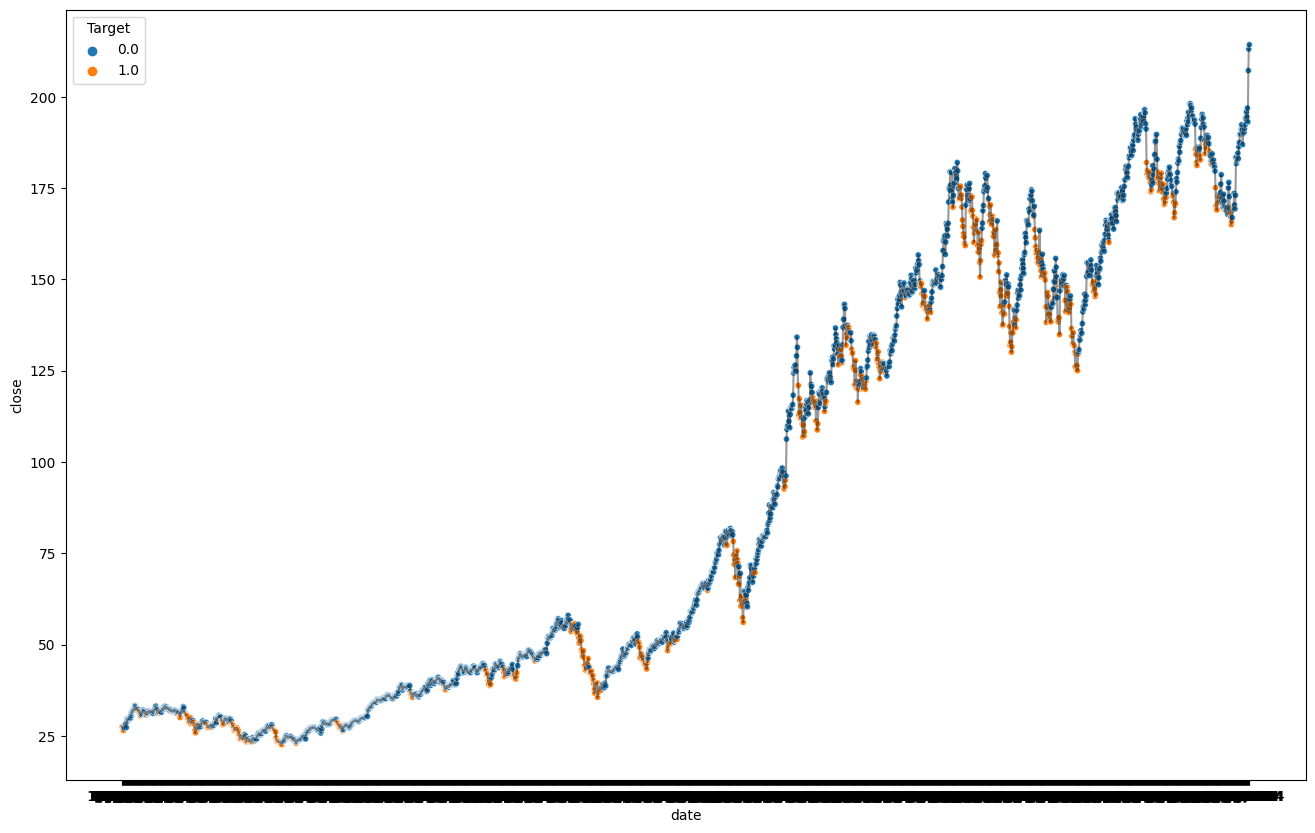

: 

In [318]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=xgb_native_predictions, x=xgb_native_predictions.index, y='close', hue='Target',s=20)